In [3]:
import os
import matplotlib.pyplot as plt # Import the Matplotlib package
# from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
 
import numpy as np # Import the Numpy package
 
from remap import remap2 # Import the Remap function
 
# from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
 
import datetime # Library to convert julian day to dd-mm-yyyy
 
from matplotlib.patches import Rectangle # Library to draw rectangles on the plot
 
from netCDF4 import Dataset # Import the NetCDF Python interface

import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable

import osr

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)


In [4]:
!ls ../../

code  data  outputs


In [7]:
root_dir = '../../data/durango_416'
root_dir = '../../data'
b6_paths = sorted(glob.glob(root_dir + '/OR_ABI-L1b-RadC-M3C06_G16_*'))
b6_paths = [os.path.abspath(p) for p in b6_paths]
b7_paths = sorted(glob.glob(root_dir + '/OR_ABI-L1b-RadC-M3C07_G16_*'))
b7_paths = [os.path.abspath(p) for p in b7_paths]


# print(b6_paths)
# print(len(b6_paths))
# os.path.abspath(b6_paths[0])

In [4]:
# #### DEBUG
# from osgeo import gdal
# path = b6_paths[0]
# try:  
#     print('try')
#     #raw = gdal.Open('NETCDF:"'+path+'":Rad')
#     connectionInfo = 'NETCDF:'+path+':Rad' 
#     print(connectionInfo)
#     raw = gdal.Open(connectionInfo)
#     print(raw)
#     # store the numpy array
#     raw2 = raw.ReadAsArray()

# except:
#     print('try2')
#     connectionInfo = 'HDF5:\"' + path + r'\"://Rad'   
#     # Open NetCDF file (GOES-16 data)  
#     raw = gdal.Open(connectionInfo)
#     # store the numpy array
#     raw2 = raw.ReadAsArray()

# print(raw2.min())
# # store the numpy array
# # raw2 = raw.ReadAsArray()

# # connectionInfo = 'NETCDF:\"' + path + '\":CMI'   
# # # Open NetCDF file (GOES-16 data)  
# # raw = gdal.Open(connectionInfo)

In [8]:
# store some variables
time_ls = []
data_ls = []
grid_ls = []
date_ls = []

for path in b6_paths:
     
    # Getting information from the file name ==============================================================
    # Search for the Scan start in the file name
    Start = (path[path.find("_s")+2:path.find("_e")])
    # Search for the GOES-16 channel in the file name
    Band = int((path[path.find("M3C" or "M4C")+3:path.find("_G16")]))
    # Create a GOES-16 Bands string array
    Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
     
    # Converting from julian day to dd-mm-yyyy
    year = int(Start[0:4])
    dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
    dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
    date = dayconventional.strftime('%d-%b-%Y') # Format the date according to the strftime directives
    date_ls.append(date)
    
    time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
    time_ls.append(time)
    
    # Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
    if Band <= 6:
        Unit = "Reflectance"
    else:
        Unit = "Brightness Temperature [°C]"

    # Open the file using the NetCDF4 library
    nc = Dataset(path)
     
    # Get the latitude and longitude image bounds
    geo_extent = nc.variables['geospatial_lat_lon_extent']
    min_lon = float(geo_extent.geospatial_westbound_longitude)
    max_lon = float(geo_extent.geospatial_eastbound_longitude)
    min_lat = float(geo_extent.geospatial_southbound_latitude)
    max_lat = float(geo_extent.geospatial_northbound_latitude)
     
    # Choose the visualization extent (min lon, min lat, max lon, max lat)
    #extent = [-85.0, -5.0, -60.0, 12.0]
    extent = [min_lon, min_lat, max_lon, max_lat]
     
    # Choose the image resolution (the higher the number the faster the processing is)
    resolution = 2.0
     
    # Calculate the image extent required for the reprojection
    H = nc.variables['goes_imager_projection'].perspective_point_height
    x1 = nc.variables['x_image_bounds'][0] * H
    x2 = nc.variables['x_image_bounds'][1] * H
    y1 = nc.variables['y_image_bounds'][1] * H
    y2 = nc.variables['y_image_bounds'][0] * H
     
    # Call the reprojection function
    ## DEBUG try some different projections
    targetPrj = osr.SpatialReference()
    targetPrj.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
#     targetPrj.ImportFromProj4('+proj=lcc +lon_0=-90')
    raw,grid = remap2(path, extent, resolution, x1, y1, x2, y2, targetPrj)
    grid_ls.append(grid)
     
    # Read the data returned by the function
    if Band <= 6:
        data = grid.ReadAsArray()
    else:
        # If it is an IR channel subtract 273.15 to convert to ° Celsius
        data = grid.ReadAsArray() - 273.15
        
    data_ls.append(data)

In [9]:
# store some variables
time_ls7 = []
data_ls7 = []
grid_ls7 = []
date_ls7 = []

for path in b7_paths:
     
    # Getting information from the file name ==============================================================
    # Search for the Scan start in the file name
    Start = (path[path.find("_s")+2:path.find("_e")])
    # Search for the GOES-16 channel in the file name
    Band = int((path[path.find("M3C" or "M4C")+3:path.find("_G16")]))
    # Create a GOES-16 Bands string array
    Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
     
    # Converting from julian day to dd-mm-yyyy
    year = int(Start[0:4])
    dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
    dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
    date = dayconventional.strftime('%d-%b-%Y') # Format the date according to the strftime directives
    date_ls7.append(date)
    
    time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
    time_ls7.append(time)
    
    # Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
    if Band <= 6:
        Unit = "Reflectance"
    else:
        Unit = "Brightness Temperature [°C]"

    # Open the file using the NetCDF4 library
    nc = Dataset(path)
     
    # Get the latitude and longitude image bounds
    geo_extent = nc.variables['geospatial_lat_lon_extent']
    min_lon = float(geo_extent.geospatial_westbound_longitude)
    max_lon = float(geo_extent.geospatial_eastbound_longitude)
    min_lat = float(geo_extent.geospatial_southbound_latitude)
    max_lat = float(geo_extent.geospatial_northbound_latitude)
     
    # Choose the visualization extent (min lon, min lat, max lon, max lat)
    #extent = [-85.0, -5.0, -60.0, 12.0]
    extent = [min_lon, min_lat, max_lon, max_lat]
     
    # Choose the image resolution (the higher the number the faster the processing is)
    resolution = 2.0
     
    # Calculate the image extent required for the reprojection
    H = nc.variables['goes_imager_projection'].perspective_point_height
    x1 = nc.variables['x_image_bounds'][0] * H
    x2 = nc.variables['x_image_bounds'][1] * H
    y1 = nc.variables['y_image_bounds'][1] * H
    y2 = nc.variables['y_image_bounds'][0] * H
     
    # Call the reprojection function
    ## DEBUG try some different projections
    targetPrj = osr.SpatialReference()
    targetPrj.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
#     targetPrj.ImportFromProj4('+proj=lcc +lon_0=-90')
    raw,grid = remap2(path, extent, resolution, x1, y1, x2, y2, targetPrj)
    grid_ls7.append(grid)
     
    # Read the data returned by the function
    if Band <= 7:
        data = grid.ReadAsArray()
    else:
        # If it is an IR channel subtract 273.15 to convert to ° Celsius
        data = grid.ReadAsArray() - 273.15
        
    data_ls7.append(data)

In [10]:
if False:
    fig, ax = plt.subplots(figsize = (20,10))
    img = ax.imshow(data_ls[1])
    colorbar(img)
    plt.show()

In [11]:
goes_stack_6 = np.array(data_ls)

if False:
    fig, ax = plt.subplots(figsize = (10,5))
    img = ax.imshow(np.std(goes_stack_6, axis=0))
    colorbar(img)
    plt.show()

In [12]:
goes_shp = goes_stack_6.shape
new_shp = (goes_shp[1]*goes_shp[2], goes_shp[0])
goes_arr_6 = np.reshape(np.rollaxis(goes_stack_6, 0, 3), new_shp)
del goes_stack_6

In [13]:
zero_inds = np.where(np.std(goes_arr_6, axis=1) < 0.0001)[0]
good_inds = np.where(np.std(goes_arr_6, axis=1) > 0.001)[0]

samples = goes_arr_6[good_inds,:]
samples.shape
#plt.plot(goes_arr[good_inds,:])

(8035861, 36)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


if False:
    fig, ax = plt.subplots(figsize = (10,5))

    # x = np.arange(0, 2*np.pi, 0.01)
    img = ax.imshow(data_ls[0])


    def animate(i):
    #     line.set_ydata(np.sin(x + i/10.0))  # update the data
        ax.imshow(i[1])
        ax.set_title('frame {}'.format(i[0]))
        return img,


    # (np.arange(0,len(data_ls)),data_ls)
    ani = animation.FuncAnimation(fig, animate, zip(range(36), data_ls), blit=False, repeat=True)
    plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

if False:
    fig, ax = plt.subplots(figsize = (10,5))

    # x = np.arange(0, 2*np.pi, 0.01)
    img = ax.imshow(data_ls7[0])


    def animate(i):
    #     line.set_ydata(np.sin(x + i/10.0))  # update the data
        ax.imshow(i[1])
        ax.set_title('band 7, frame {}'.format(i[0]))
        return img,

    # (np.arange(0,len(data_ls)),data_ls)
    ani = animation.FuncAnimation(fig, animate, zip(range(36), data_ls7), blit=False, repeat=True)
    plt.show()

In [16]:
# stack the arrays for band 7
goes_stack_7 = np.array(data_ls7)
goes_shp = goes_stack_7.shape
new_shp = (goes_shp[1]*goes_shp[2], goes_shp[0])
goes_arr_7 = np.reshape(np.rollaxis(goes_stack_7, 0, 3), new_shp)
del goes_stack_7

In [17]:
zero_inds7 = np.where(np.std(goes_arr_7, axis=1) < .0001)[0]
good_inds7 = np.where(np.std(goes_arr_7, axis=1) > 0.0001)[0]

print('number of zeros: {}'.format(zero_inds7.shape))
print('number on nonzeros: {}'.format(good_inds7.shape))

samples7 = goes_arr_7[good_inds7,:]
samples7.shape, samples.shape

number of zeros: (4921165,)
number on nonzeros: (8037447,)


((8037447, 36), (8035861, 36))

## from the "nonzero" ${\sigma}$ samples, find the one with max ${\sigma}$ for each band

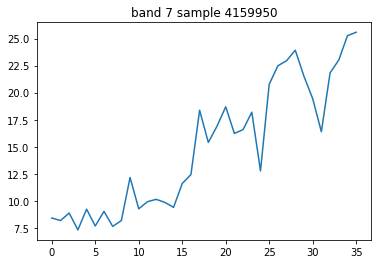

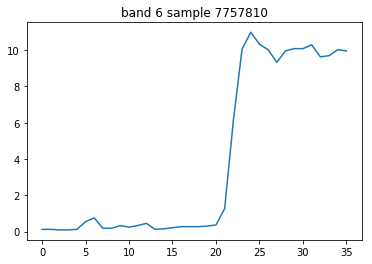

In [18]:
%matplotlib inline
test7 = np.argmax(np.std(samples7, axis=1))
plt.plot(samples7[test7,:])
plt.title('band 7 sample {}'.format(test7))
plt.show()

test6 = np.argmax(np.std(samples, axis=1))
plt.plot(samples[test6,:])
plt.title('band 6 sample {}'.format(test6))
plt.show()

1125 2618
2243 2866


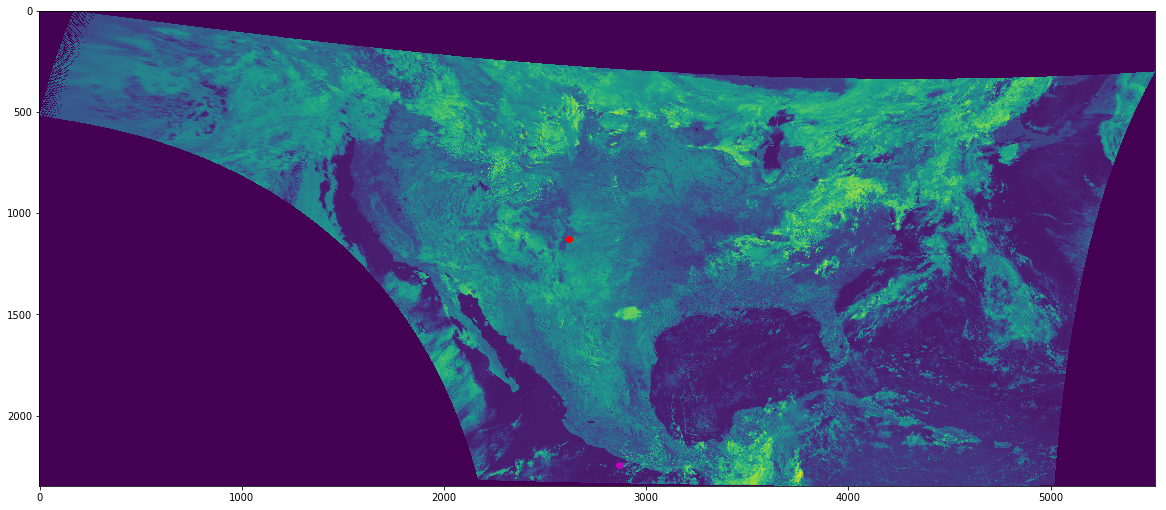

6211493 4159950


(8037447, (8037447, 36), (12958612,))

In [19]:
# get the row column for the maxes
r7,c7 = np.unravel_index(good_inds7[test7],(goes_shp[1], goes_shp[2]))
r6,c6 = np.unravel_index(good_inds[test6],(goes_shp[1], goes_shp[2]))

print(r7,c7)
print(r6,c6)
# plot them on the image
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(data_ls[20])
ax.scatter(c7,r7, c='r')
ax.scatter(c6,r6, c='m')
plt.show()

print(good_inds7[test7], test7)
len(good_inds7),samples7.shape, np.std(goes_arr_7, axis=1).shape

## look at the histograms for band-7 and band-6 $\sigma$ across time stack

(10,) (11,)


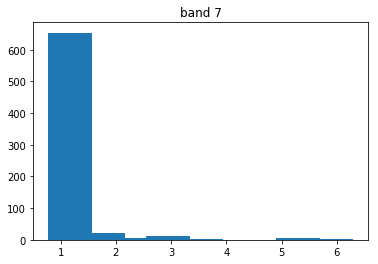

3.7252903e-09 5.886334


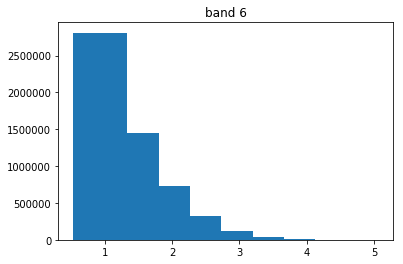

(7.450581e-09, 4.6563993)

In [20]:
hist7, bins7 = np.histogram(np.std(goes_arr_7, axis=1), bins=10)
print(hist7.shape, bins7.shape)
plt.bar(bins7[2:], hist7[1:])
plt.title('band 7')
plt.show()
print(np.min(np.std(goes_arr_7, axis=1)), np.max(np.std(goes_arr_7, axis=1)))

hist6, bins6 = np.histogram(np.std(goes_arr_6, axis=1), bins=10)
plt.bar(bins6[2:], hist6[1:])
plt.title('band 6')
plt.show()
np.min(np.std(goes_arr_6, axis=1)), np.max(np.std(goes_arr_6, axis=1))

## looks like $\sigma$ > 4.0 removes most of the data. Check it out.

In [21]:
## do the indices again for std > 4, just to see
good_inds7_new = np.where(np.std(goes_arr_7, axis=1) > 4.0)[0]
samples7_new = goes_arr_7[good_inds7_new,:]

good_inds6_new = np.where(np.std(goes_arr_6, axis=1) > 4.0)[0]
samples6_new = goes_arr_7[good_inds6_new,:]



In [22]:
samples7_new.shape, samples6_new.shape

# get the row column for the maxes
r7_n,c7_n = np.unravel_index(good_inds7_new,(goes_shp[1], goes_shp[2]))
r6_n,c6_n = np.unravel_index(good_inds6_new,(goes_shp[1], goes_shp[2]))

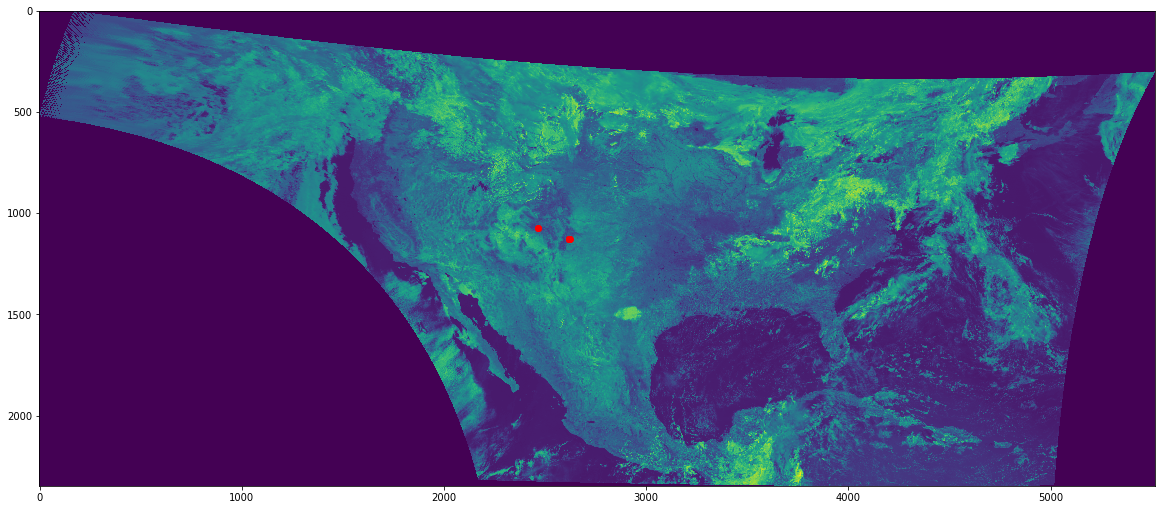

In [23]:
# plot them on the image
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(data_ls[20])
ax.scatter(c7_n,r7_n, c='r')
# ax.scatter(c6_n,r6_n, c='y')
plt.show()

## create a shapefile from the rows/cols that have $\sigma$ > 4.0

In [21]:
create_shp = False
if create_shp:
    from fiona.crs import from_epsg
    import fiona
    # project to WGS84
    from pyproj import Proj, transform
    from shapely.geometry import Point, mapping

    def getGeoT(extent, nlines, ncols):
        # Compute resolution based on data dimension
        resx = (extent[2] - extent[0]) / ncols
        resy = (extent[3] - extent[1]) / nlines
        return [extent[0], resx, 0, extent[3] , 0, -resy]


    def proj_coords(r,c,gt):

        # calculate the coordinates
    #     x7 = gt[0] + gt[1]*c
    #     y7 = gt[3] + gt[5]*r

        Xgeo = gt[0] + c*gt[1] + r*gt[2]
        Ygeo = gt[3] + c*gt[4] + r*gt[5]

    #     inProj = Proj('+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414 +f=0.00335281068119356027489803406172 +lat_0=0.0 +lon_0=-75.0 +sweep=x +no_defs')
    #     outProj = Proj(init='epsg:4326')
    #     xp,yp = transform(inProj,outProj,x7,y7)
    #     xp,yp = transform(inProj,outProj,Xgeo,Ygeo)

        return Xgeo,Ygeo


    # Calculate the image extent required for the reprojection
    H = nc.variables['goes_imager_projection'].perspective_point_height
    x1 = nc.variables['x_image_bounds'][0] * H
    x2 = nc.variables['x_image_bounds'][1] * H
    y1 = nc.variables['y_image_bounds'][1] * H
    y2 = nc.variables['y_image_bounds'][0] * H
    gt = getGeoT([x1,y1,x2,y2], data_ls[0].shape[0], data_ls[0].shape[1])
    print(gt)

    ## save the points
    out_shp7 = r'C:\Projects\RD\OPIR_GOES\shp\band7_std_gt4.shp'
    out_shp6 = r'C:\Projects\RD\OPIR_GOES\shp\band6_std_gt42.shp'


    yourschema =  {'geometry': 'Point',
                   'properties': {'band': 'int'}}

    gtf = grid.GetGeoTransform()
    with fiona.open(out_shp6, 'w',crs=from_epsg(4326),driver='ESRI Shapefile', schema=yourschema) as out_shp:
        #reader = csv.DictReader(finalout)
        for c,r in zip(c6_n, r6_n):

            # geometry
            px, py = proj_coords(r,c,gtf)
            point = Point(px, py)
            # attributes
            prop = {'band': 6}
            # write the row (geometry + attributes in GeoJSON format)
            out_shp.write({'geometry': mapping(point), 'properties':prop})


### points are not mapping... try to create a thematic raster

In [24]:
band_6_detections = np.zeros(data_ls[0].shape)
band_7_detections = np.zeros(data_ls[0].shape)

band_6_detections[r6_n,c6_n] = 6
band_7_detections[r7_n, c7_n] = 7
goes_detections = band_6_detections + band_7_detections

np.max(goes_detections)


13.0

In [25]:
# help(grid)
gtf = grid_ls[0].GetGeoTransform()
print(gtf)

# lat/lon of c/r
print(c7,r7)
lon7 = gtf[0] + gtf[1]*c7
lat7 = gtf[3] + gtf[5]*r7
print(lat7,lon7)

lon6 = gtf[0] + gtf[1]*c6
lat6 = gtf[3] + gtf[5]*r6
print(lat6, lon6)

Xgeo = gtf[0] + c7*gtf[1] + r7*gtf[2]
Ygeo = gtf[3] + c7*gtf[4] + r7*gtf[5]
print(Xgeo, Ygeo)

(-152.10928344726562, 0.01796745843571108, 0.0, 56.761451721191406, 0.0, -0.017968531564715774)
2618 1125
36.54685371088616 -105.07047726257402
16.45803542153393 -100.61454757051766
-105.07047726257402 36.54685371088616


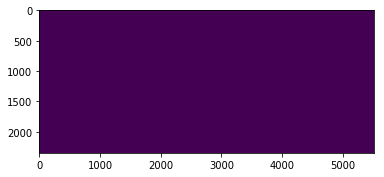

In [26]:
# make the list into an array (time will be dim=0)
data_arr = np.array(data_ls)    

# make an array of zeros to match
shp = data_ls[0].shape
targets = np.zeros((shp[0]*shp[1],1))

# reshape
data_arr = np.rollaxis(data_arr, 0, 3)
data_vec = np.reshape(data_arr, (shp[0]*shp[1], -1))

# make into a pandas data frame
import pandas as pd
        
dts = []
for i,t in enumerate(time_ls):
    s = 'UTC_' + t.replace(':','').replace(' ','').replace('UTC', '')
    dt = (s, 'float32')    
    dts.append(dt)
    
# restructure the numpy array for use in a pandas dataframe
myRecord = np.core.records.array(list(tuple(data_vec.transpose())), dtype=dts)
df = pd.DataFrame(myRecord)


absmax = data_vec.max(axis=1).max()
loc = np.where(data_vec.max(axis=1) == absmax)[0]

targets[loc]=1
plt.imshow(np.reshape(targets, (shp[0], shp[1])))
plt.show()

### write out the detection raster

In [27]:
write_them_raster = False

if write_them_raster:
    from osgeo import gdal, osr
    driver = gdal.GetDriverByName('GTiff')
    rows,cols = data_ls[23].shape

    out_folder = '../../outputs'
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)


    fname = dts[23][0] + "_" + date_ls[23].replace('-','') + '_GOES_band6_band7_detections.tif'
    fname = os.path.join(out_folder, fname)
    dst_ds = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dst_ds.SetGeoTransform(grid_ls[23].GetGeoTransform())
    #srs = osr.SpatialReference()
    #srs.ImportFromWkt(projInfo)
    dst_ds.SetProjection(grid_ls[23].GetProjection()) 

    # Write out_arr to band
    dst_ds.GetRasterBand(1).WriteArray(goes_detections)

    # Flush to disk and close file
    dst_ds.FlushCache()
    dst_ds = None


#### Write out one of the rasters

In [26]:
write_band_raster = False

if write_band_raster:
    from osgeo import gdal, osr
    driver = gdal.GetDriverByName('GTiff')
    rows,cols = data_ls[23].shape

    fname = dts[23][0] + "_" + date_ls[23].replace('-','') + '_GOES_L1B_RAD_Durango_wgs84.tif'
    dst_ds = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
    dst_ds.SetGeoTransform(grid_ls[23].GetGeoTransform())
    #srs = osr.SpatialReference()
    #srs.ImportFromWkt(projInfo)
    dst_ds.SetProjection(grid_ls[23].GetProjection()) 

    # Write out_arr to band
    dst_ds.GetRasterBand(1).WriteArray(data_ls[23])

    # Flush to disk and close file
    dst_ds.FlushCache()
    dst_ds = None



## try a thresholding algorithm (smoothed z-score) on samples with $\sigma$ > 4.0

In [27]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

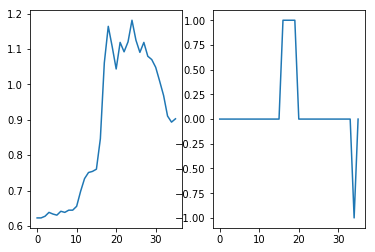

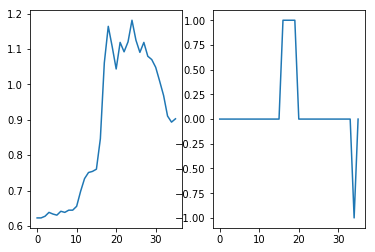

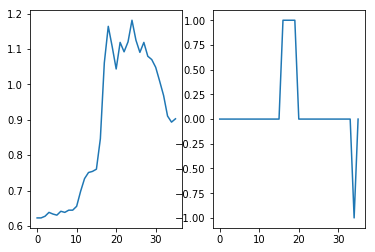

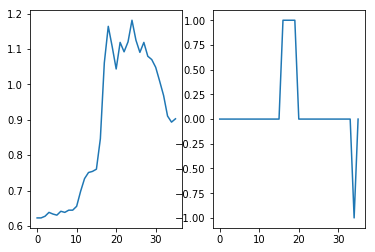

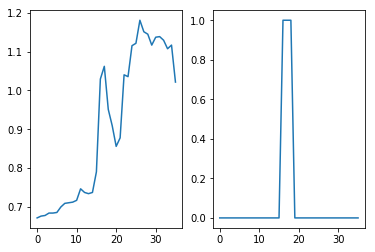

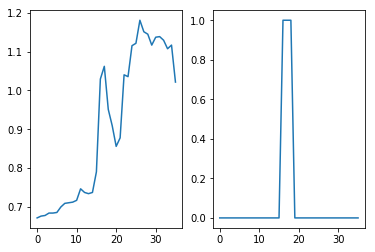

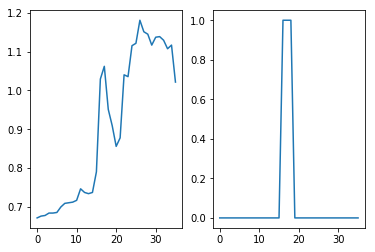

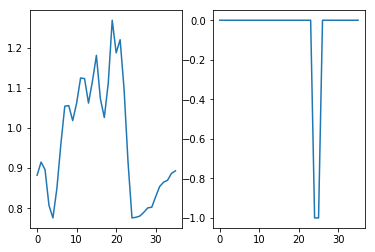

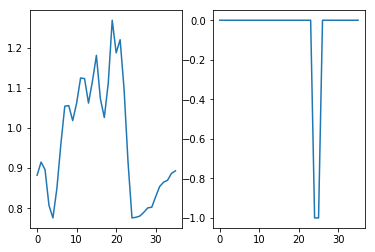

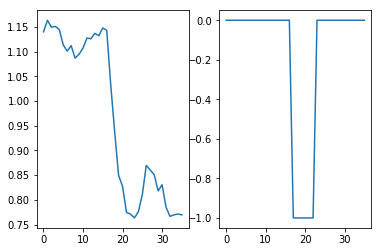

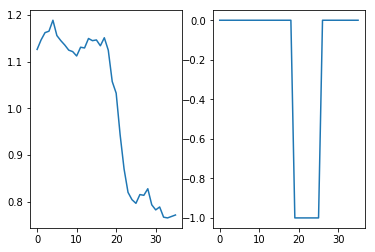

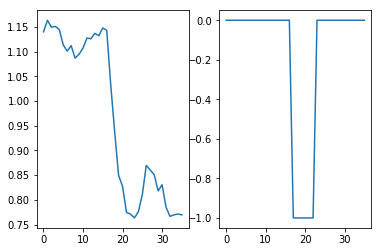

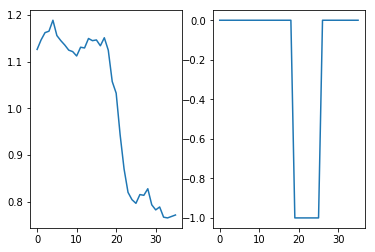

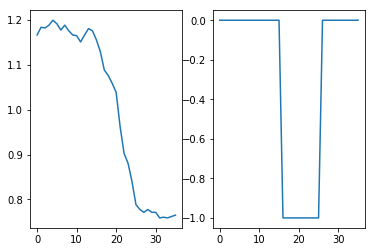

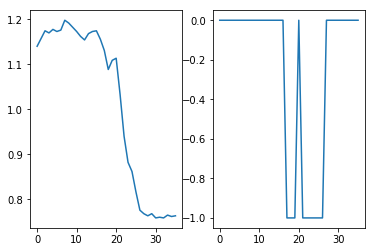

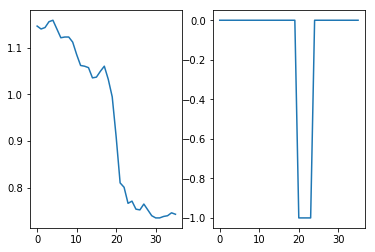

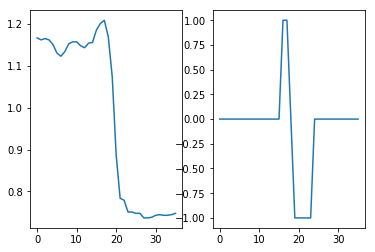

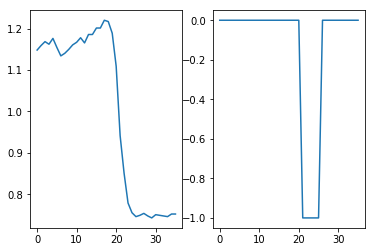

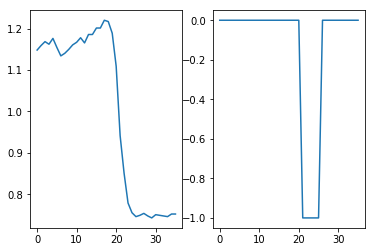

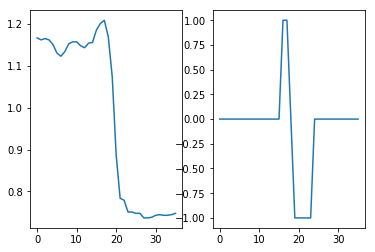

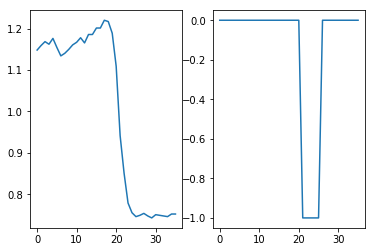

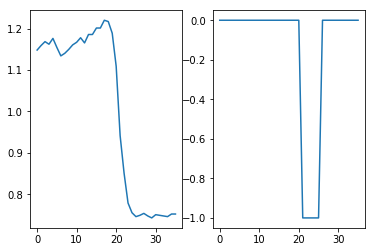

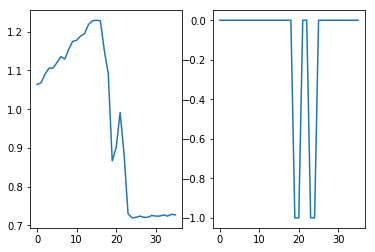

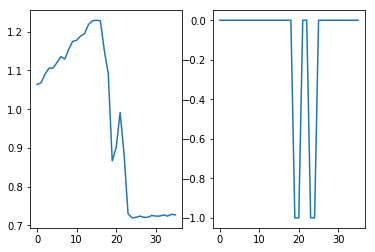

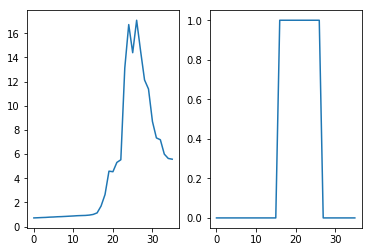

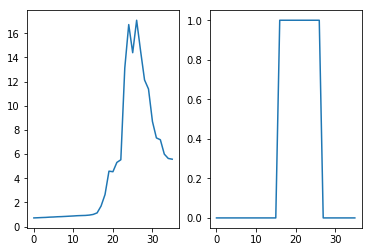

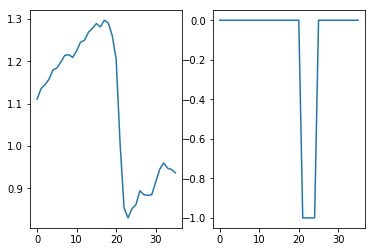

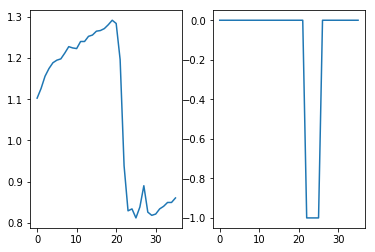

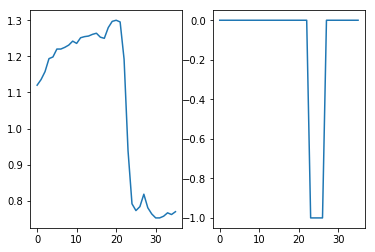

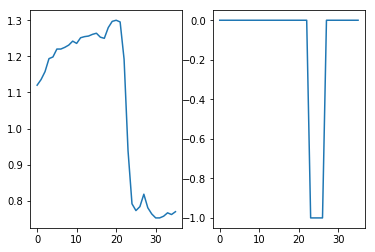

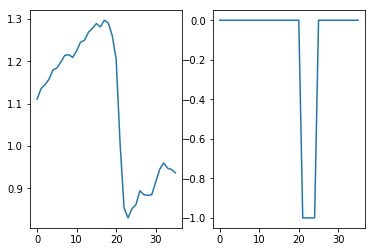

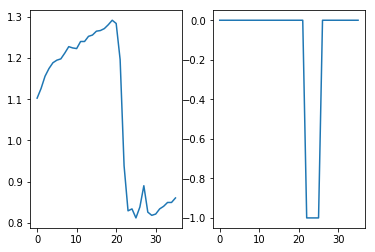

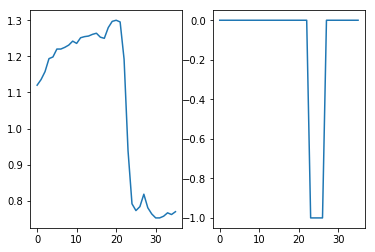

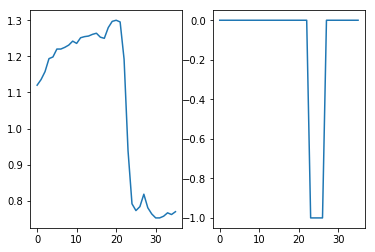

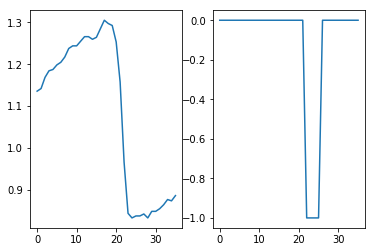

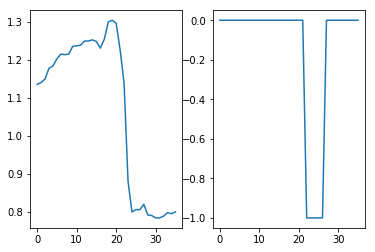

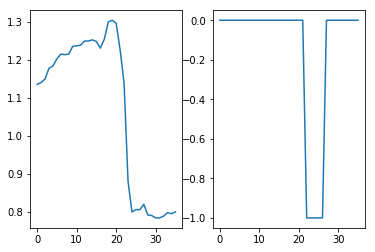

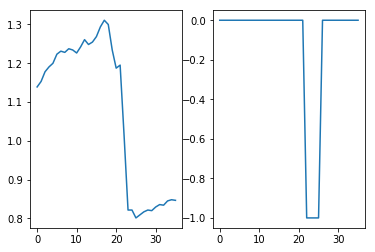

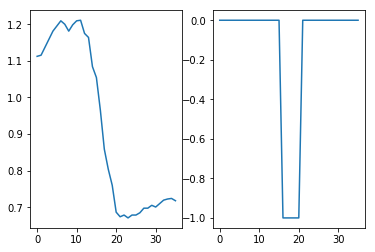

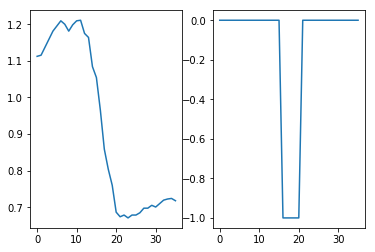

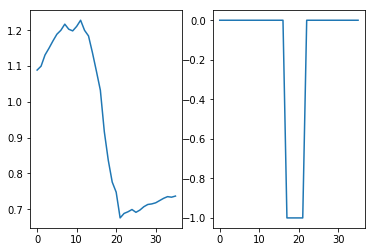

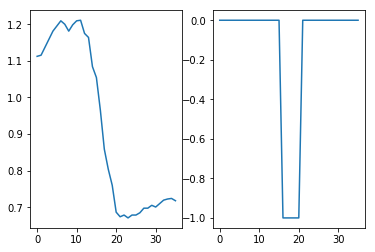

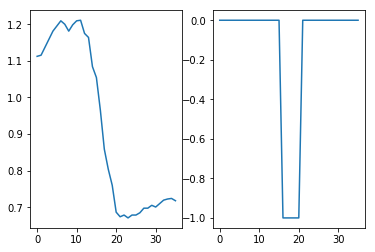

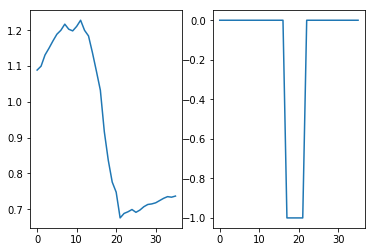

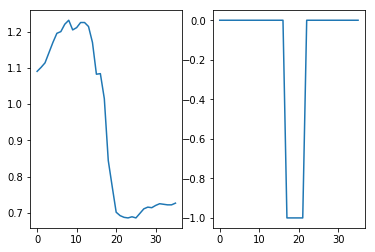

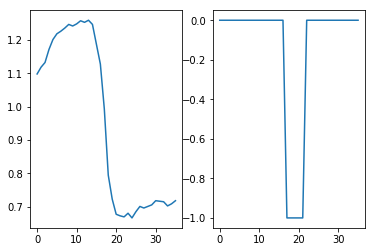

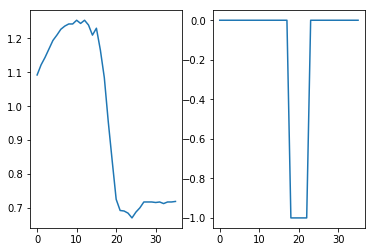

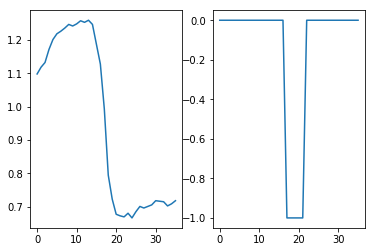

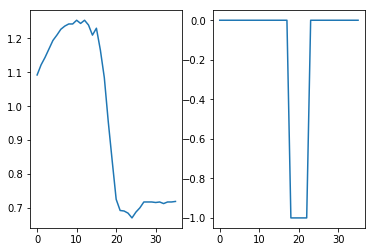

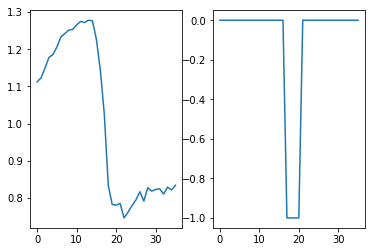

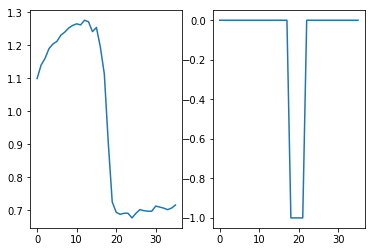

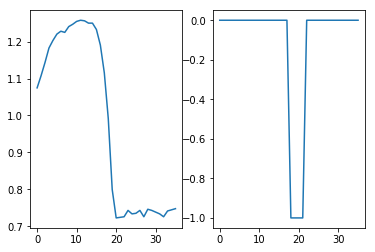

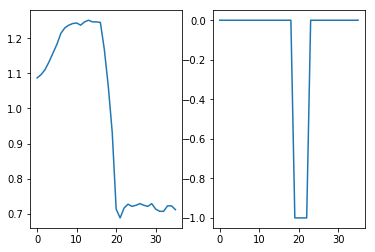

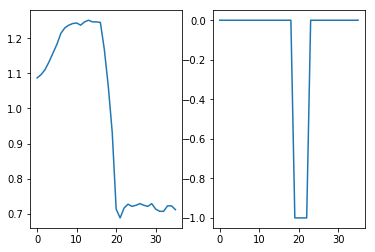

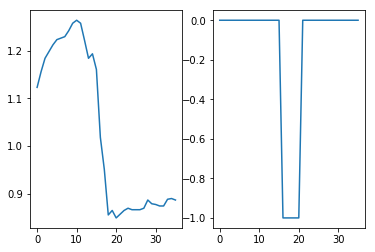

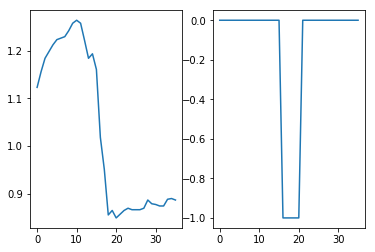

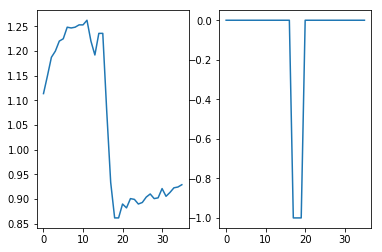

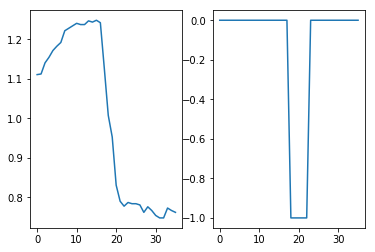

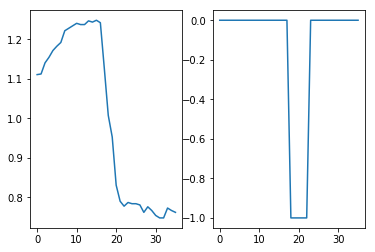

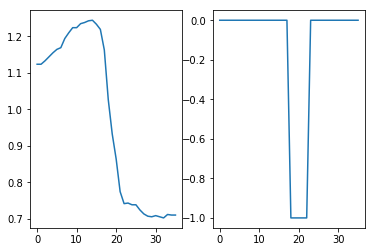

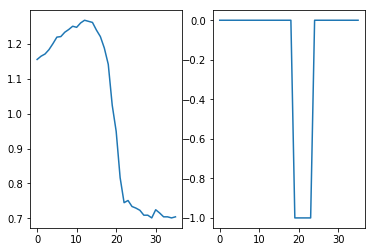

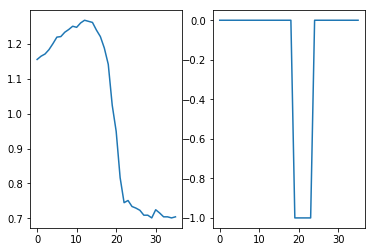

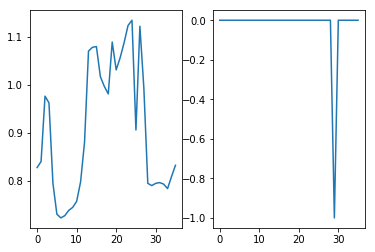

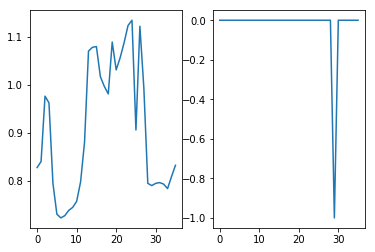

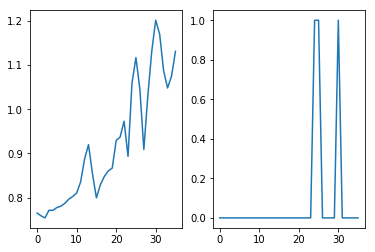

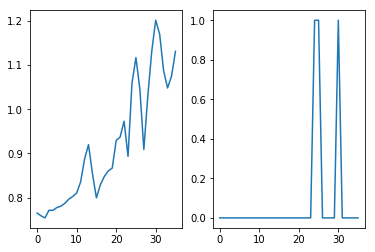

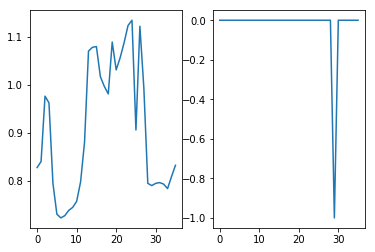

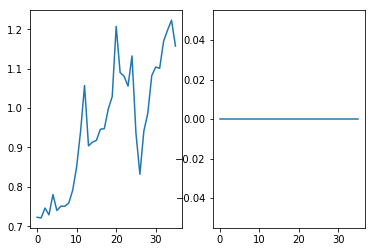

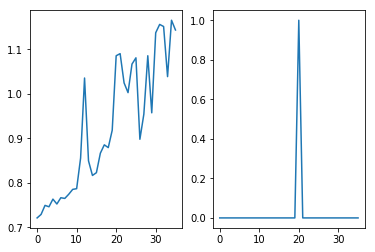

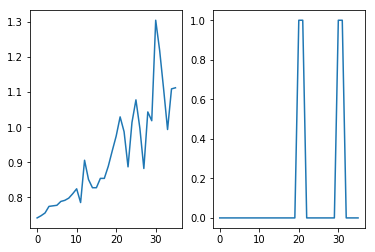

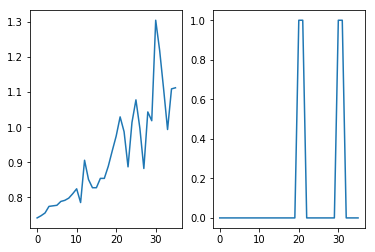

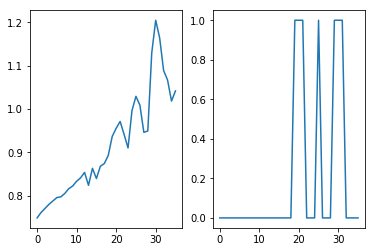

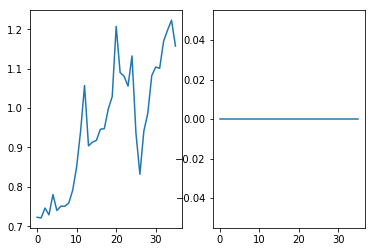

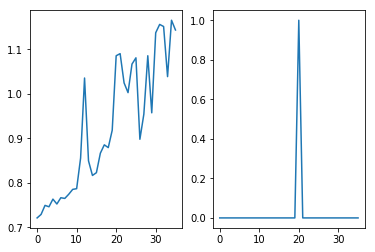

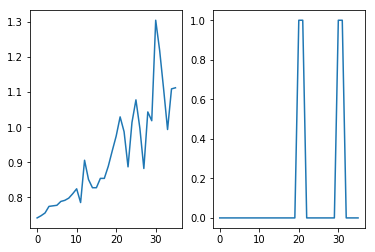

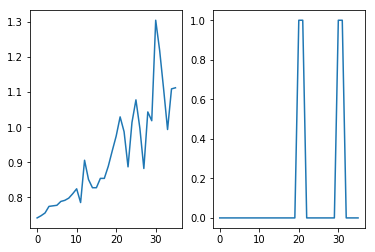

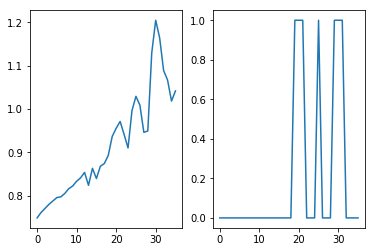

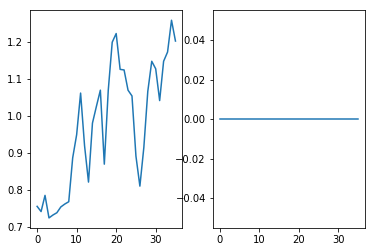

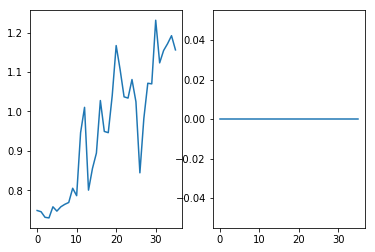

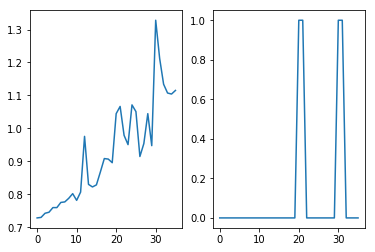

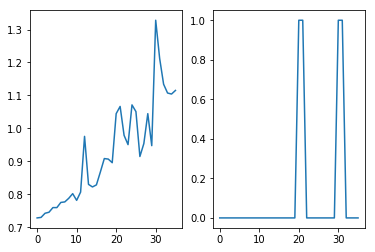

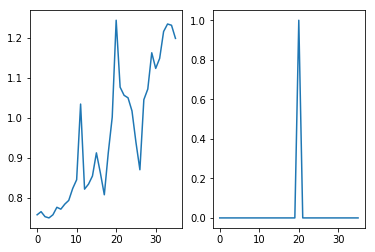

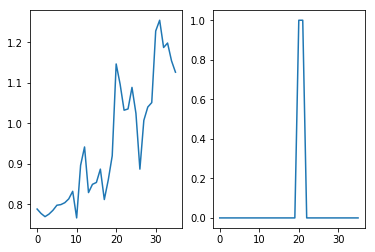

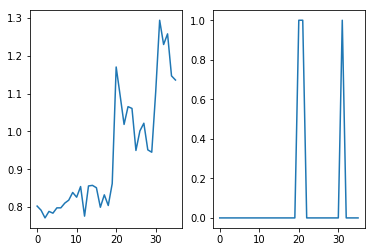

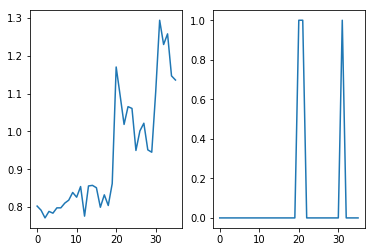

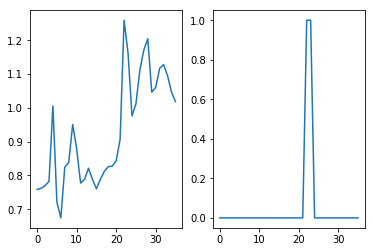

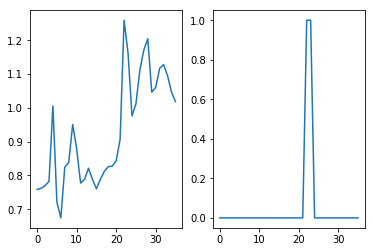

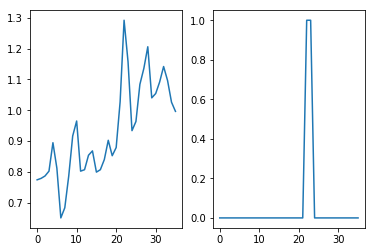

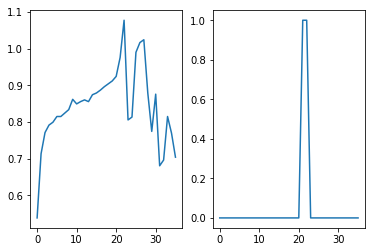

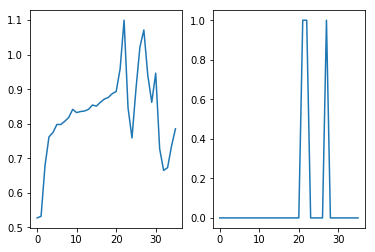

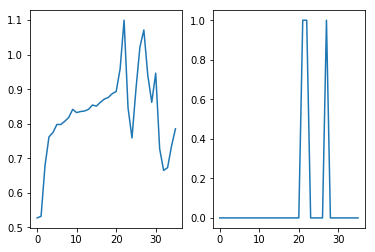

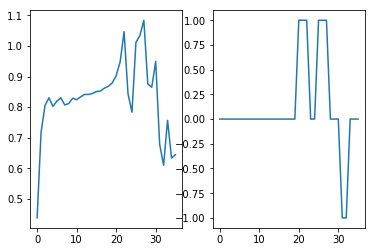

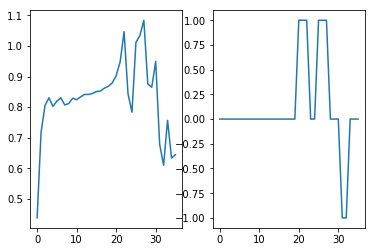

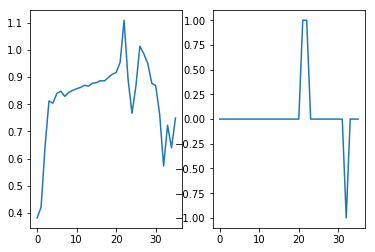

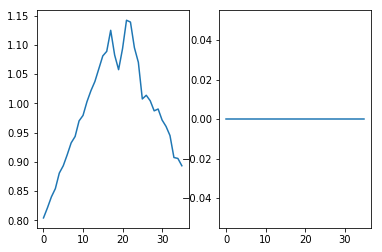

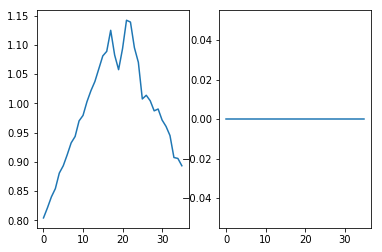

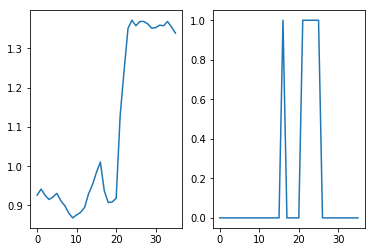

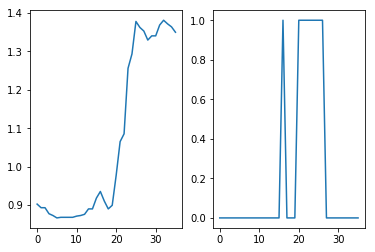

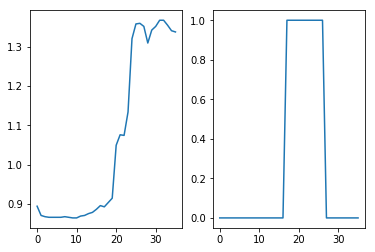

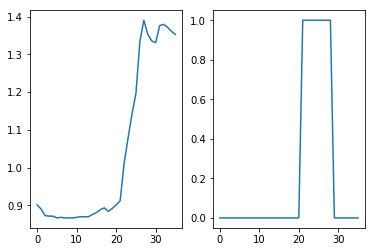

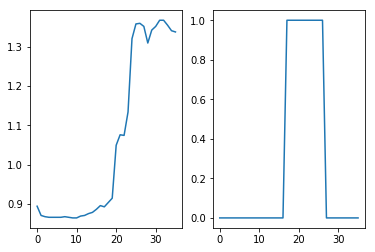

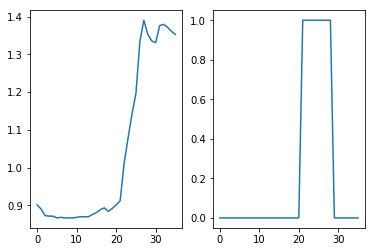

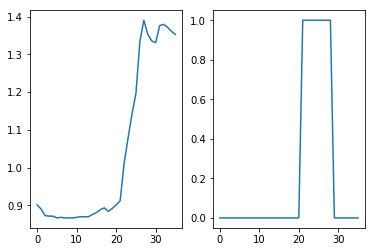

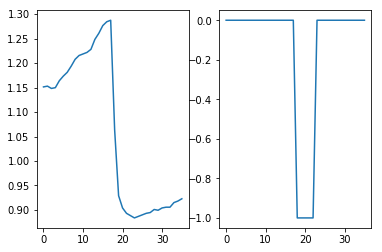

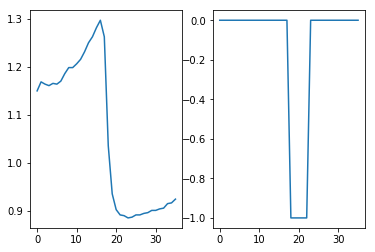

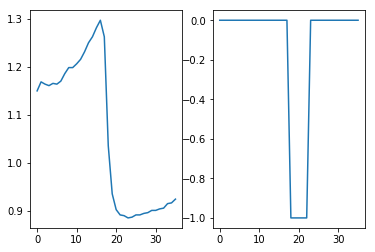

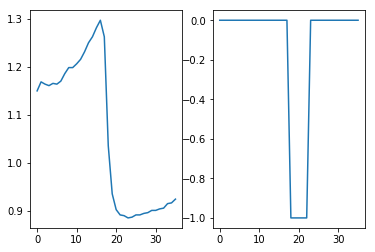

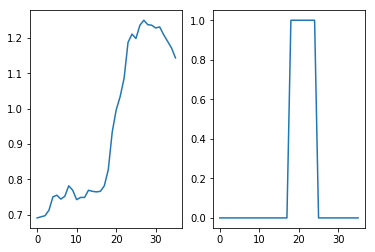

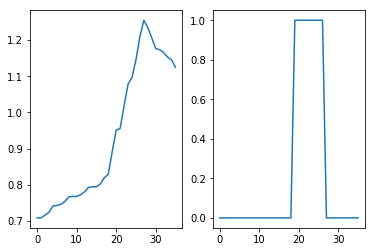

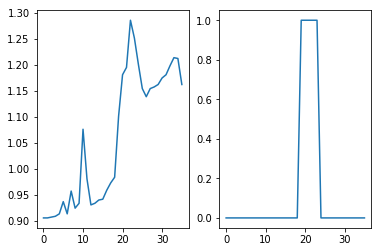

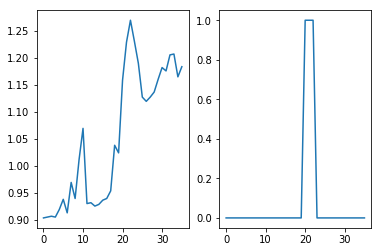

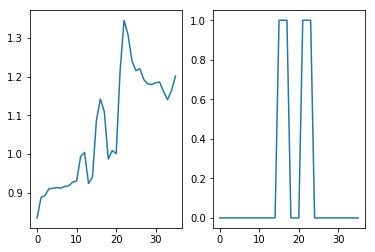

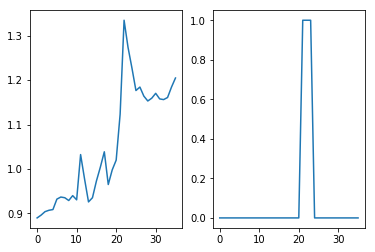

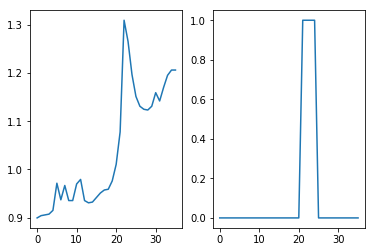

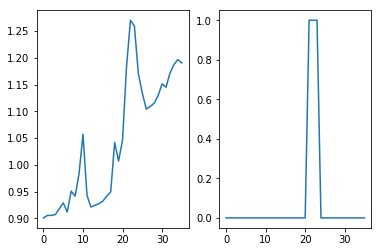

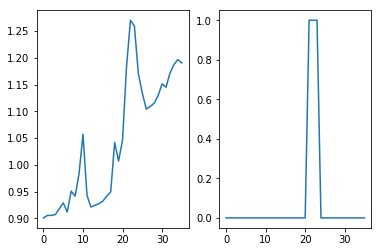

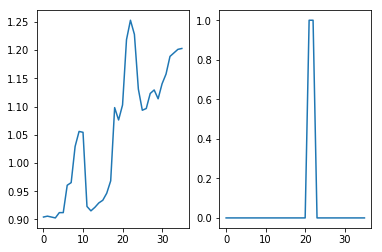

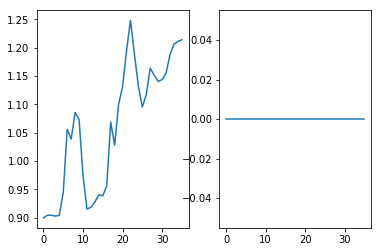

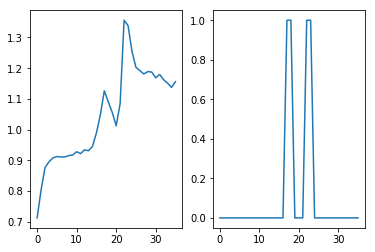

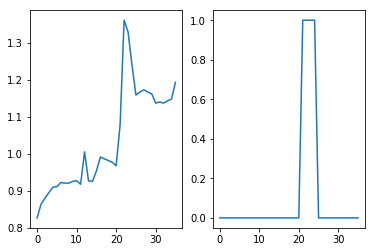

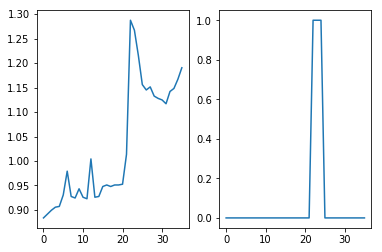

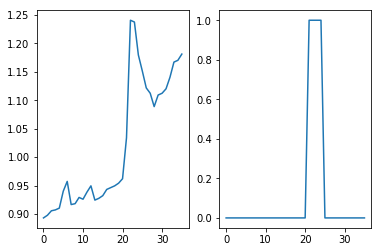

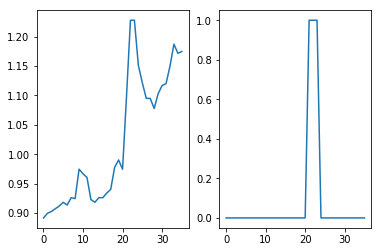

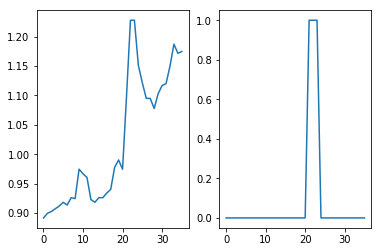

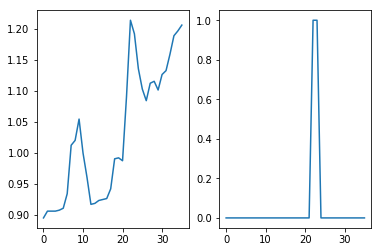

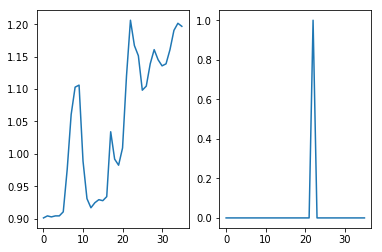

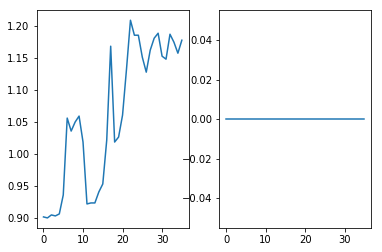

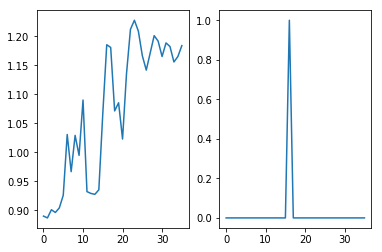

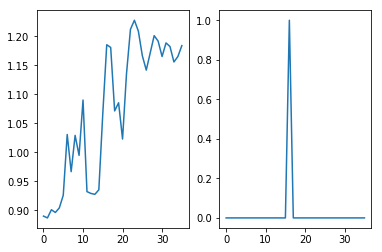

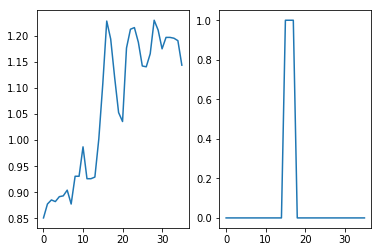

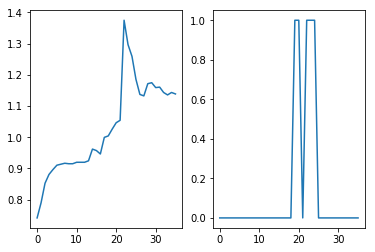

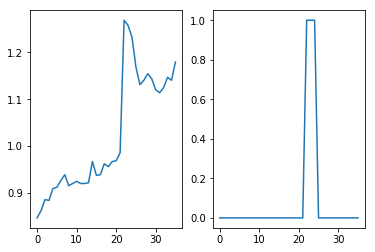

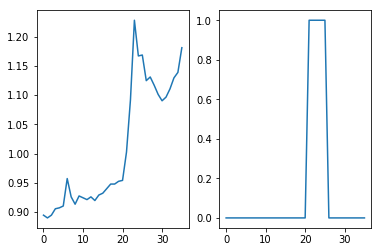

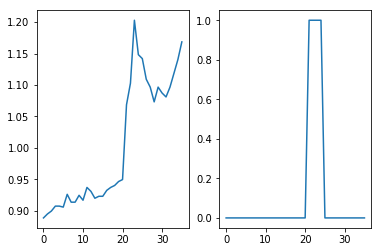

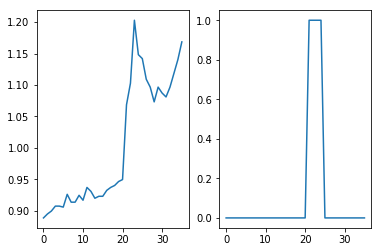

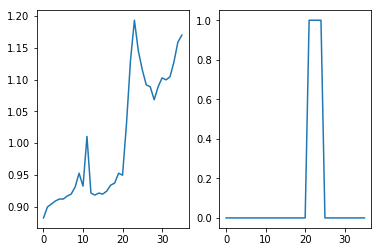

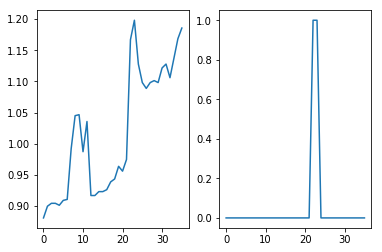

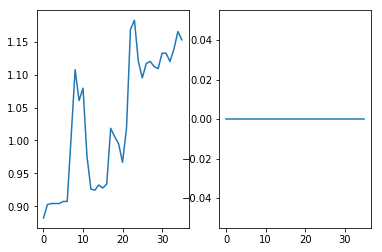

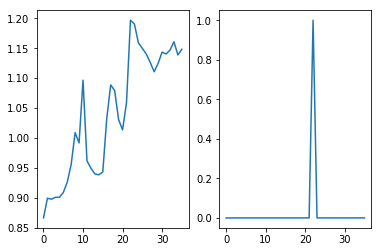

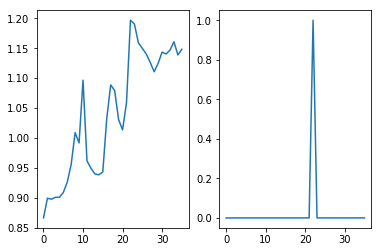

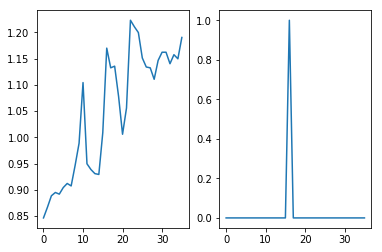

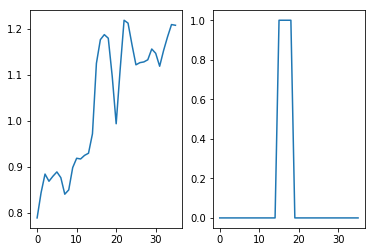

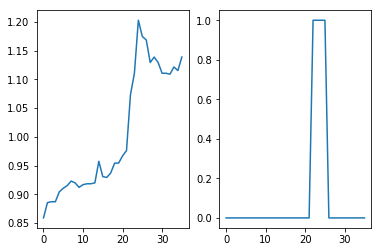

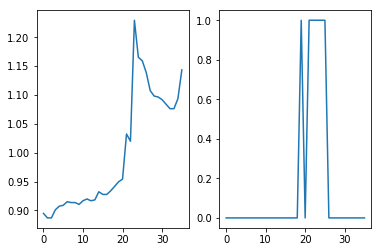

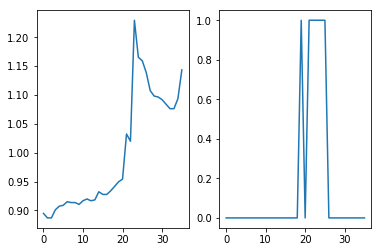

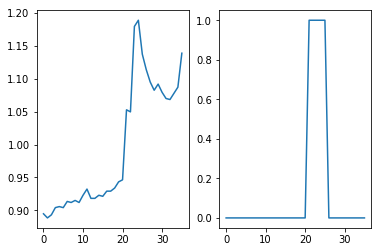

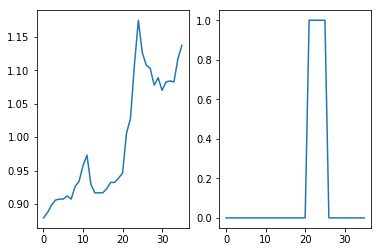

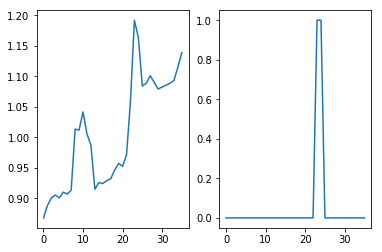

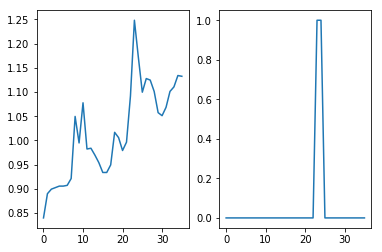

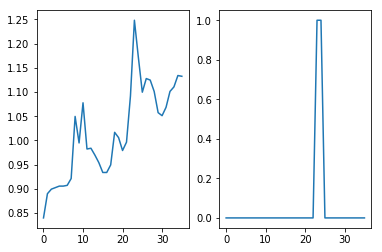

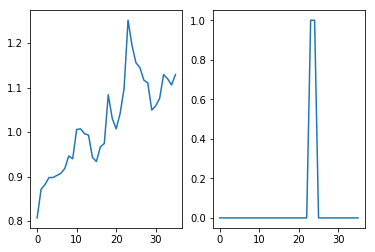

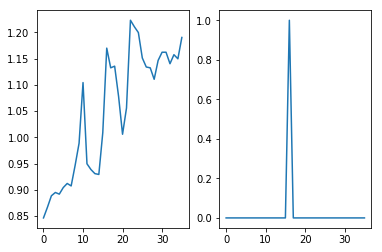

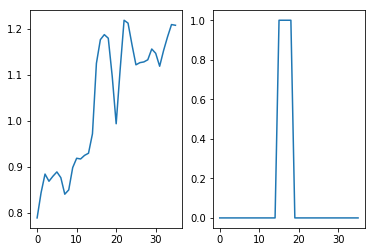

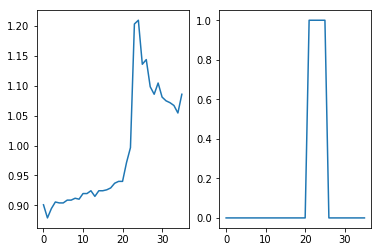

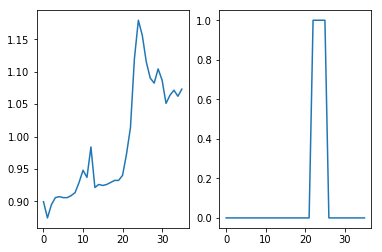

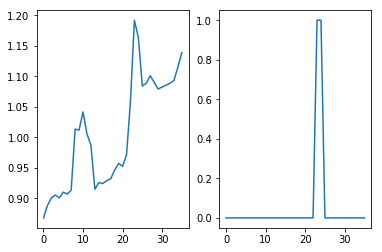

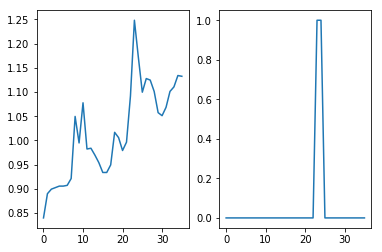

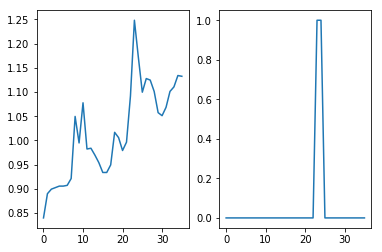

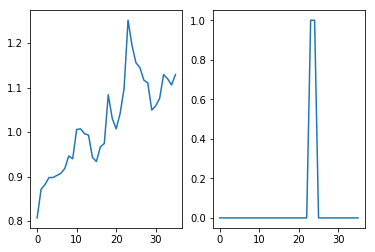

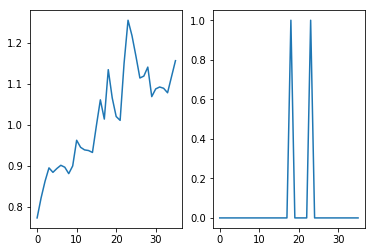

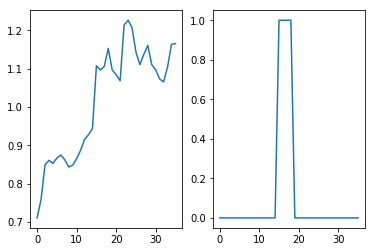

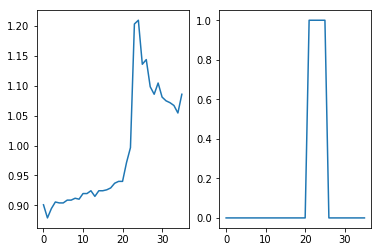

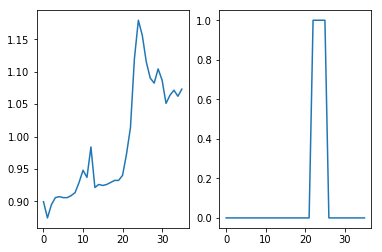

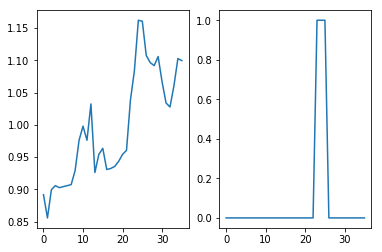

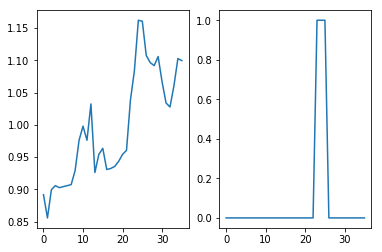

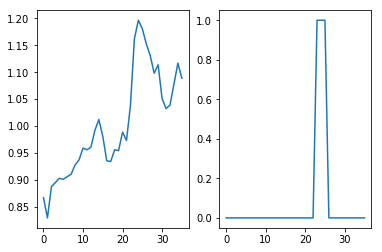

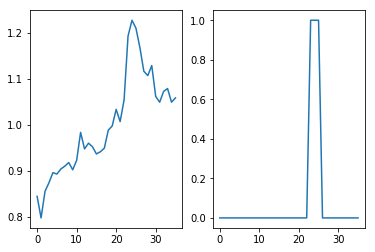

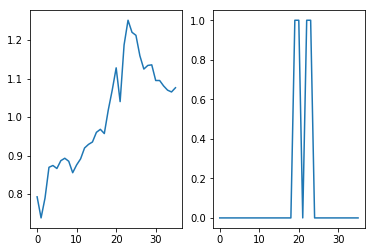

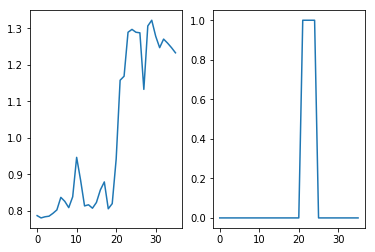

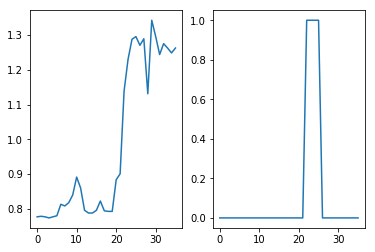

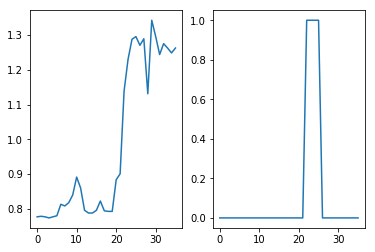

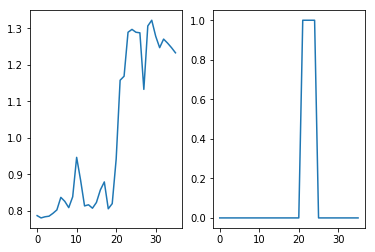

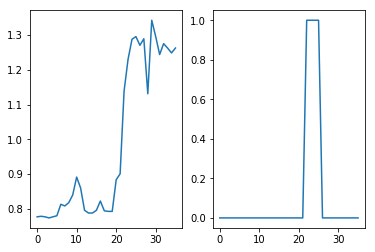

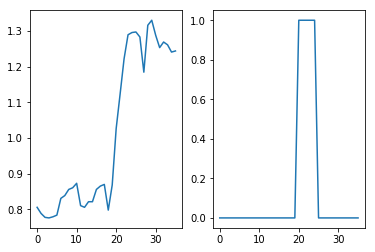

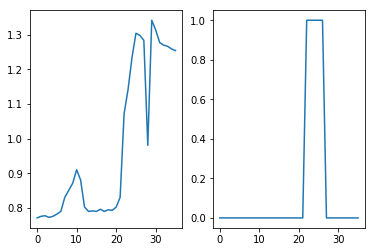

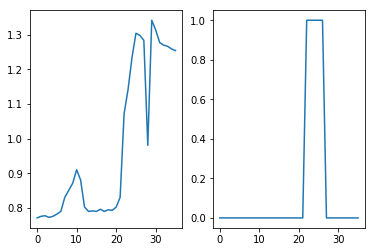

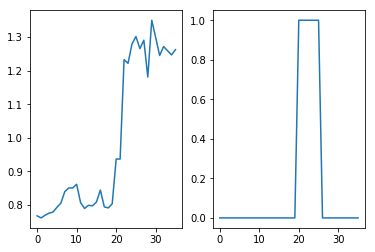

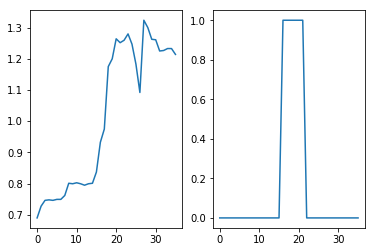

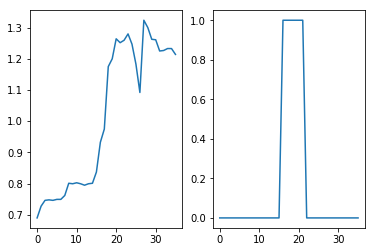

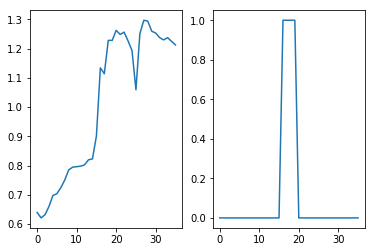

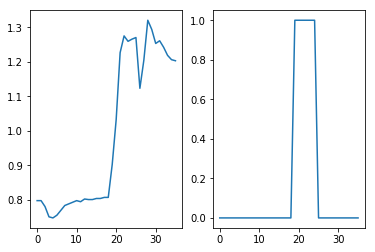

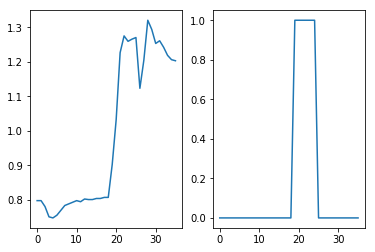

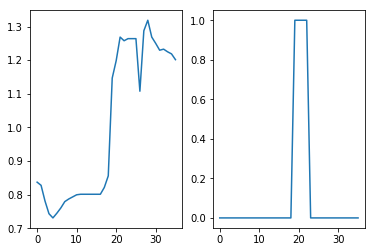

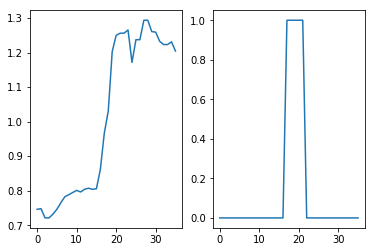

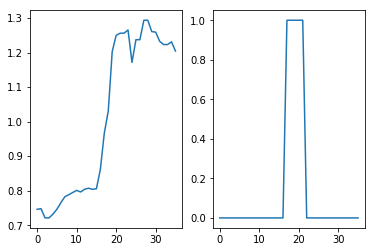

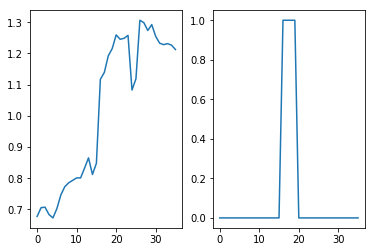

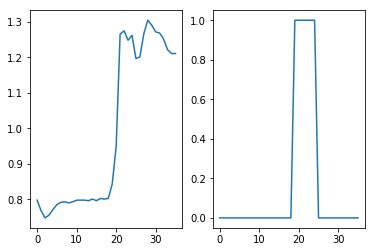

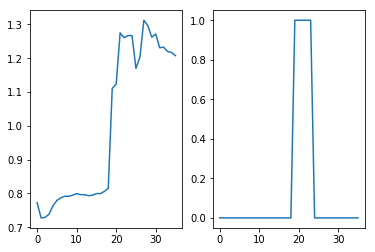

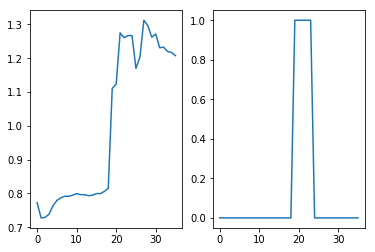

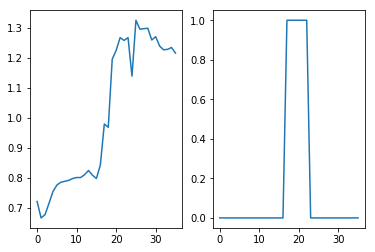

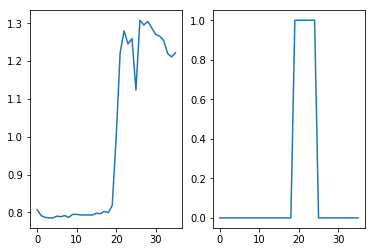

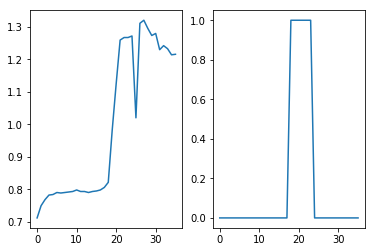

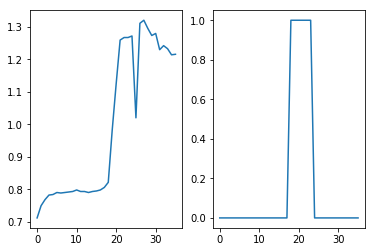

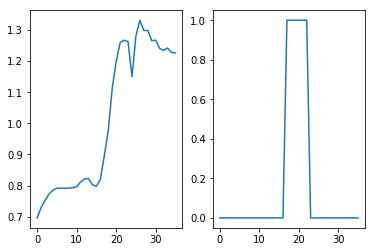

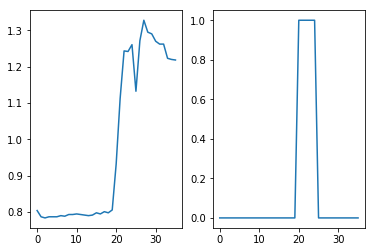

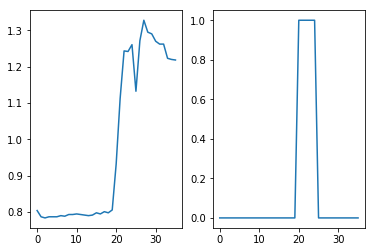

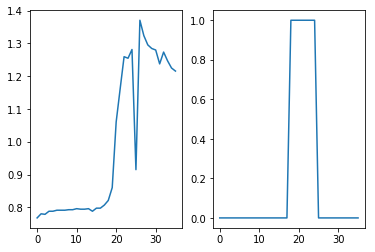

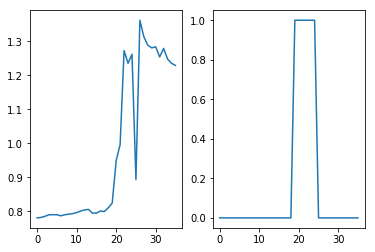

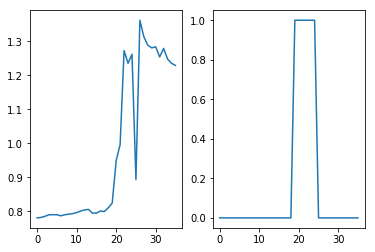

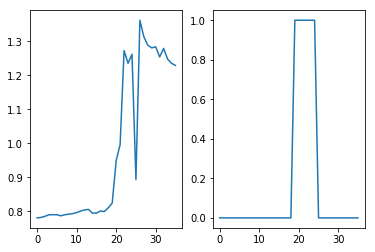

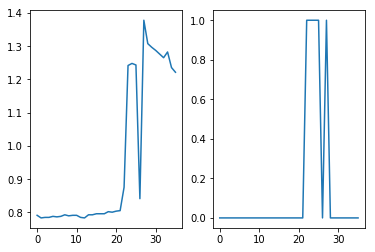

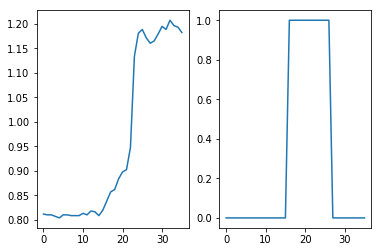

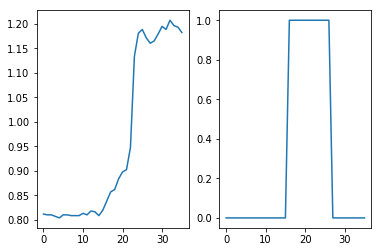

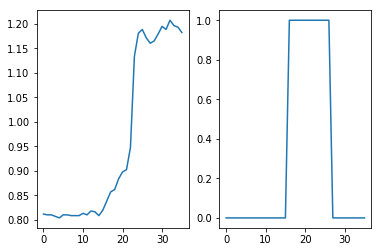

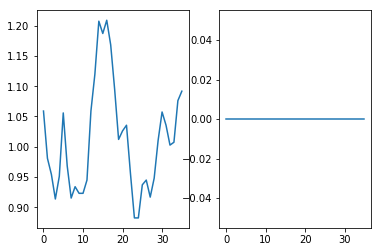

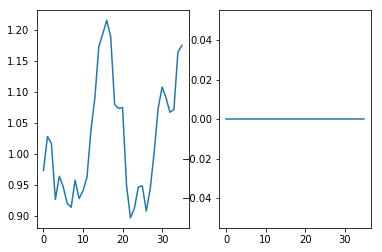

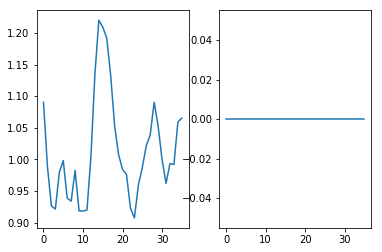

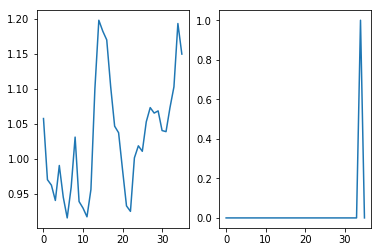

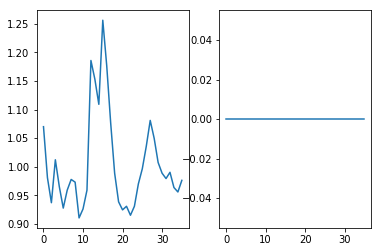

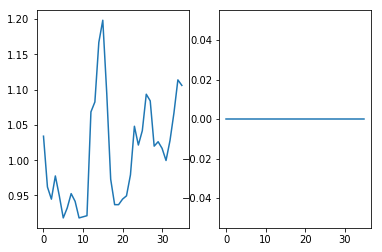

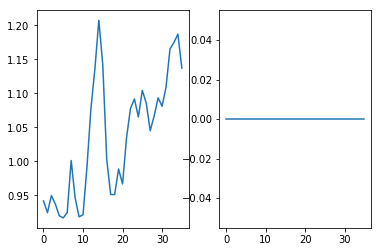

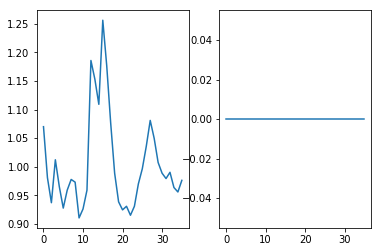

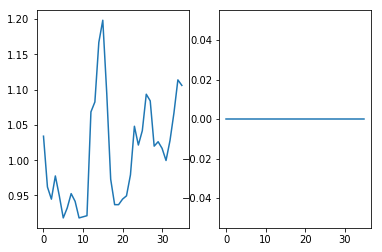

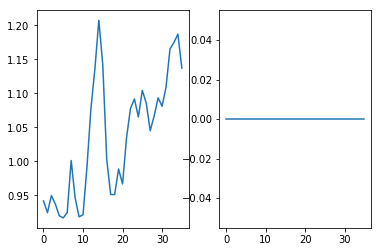

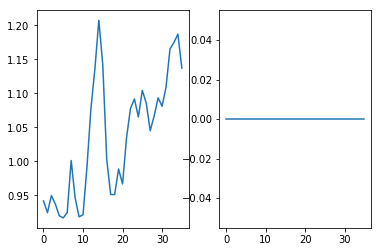

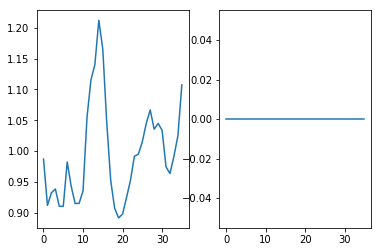

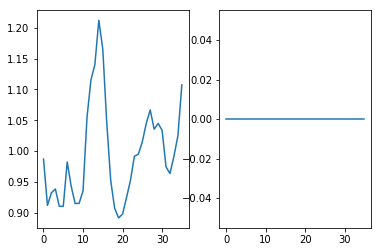

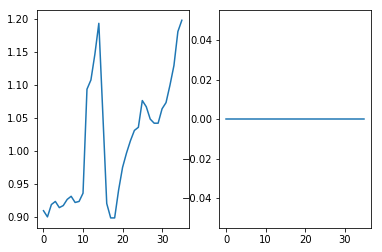

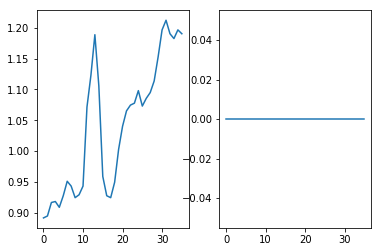

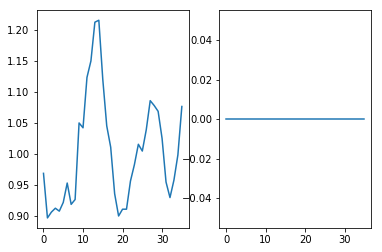

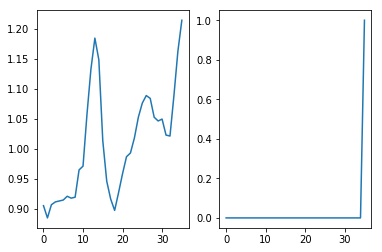

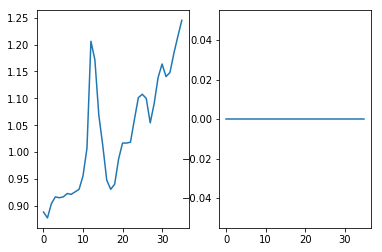

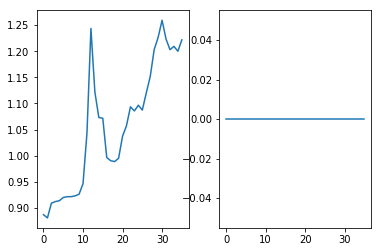

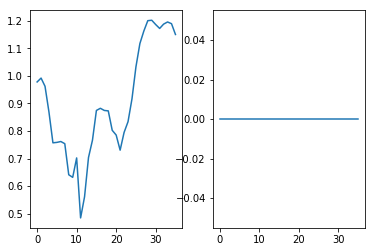

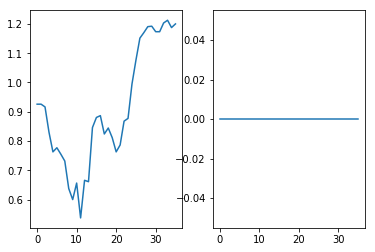

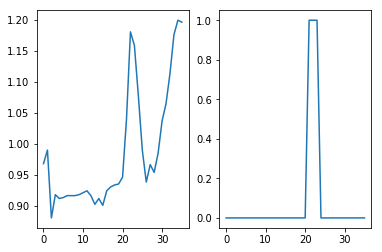

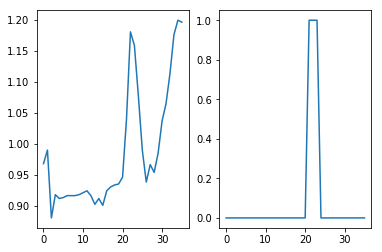

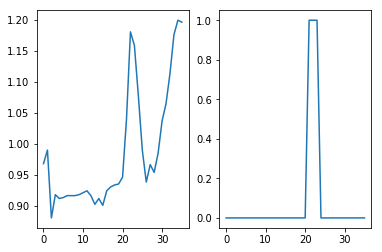

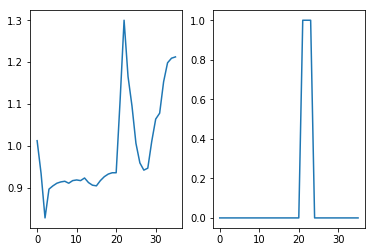

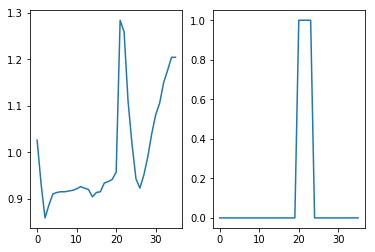

In [28]:
# plot the pixel signals with the 'detector' signal from smoothed z-score filter
lag=15
thresh=3.5
influence=0.5

for signal in samples6_new:
    # ind = good_inds6_new[2]
#     signal = samples6_new[ind,:]

    fig,ax = plt.subplots(1,2)
    ax[0].plot(signal)
    
    test = thresholding_algo(signal, lag,thresh,influence)
    ax[1].plot(test['signals'])
    plt.show()




In [28]:
# find where the band6 and band7 indexes match
np.where(r7_n == r6_n)[0]

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


array([], dtype=int64)

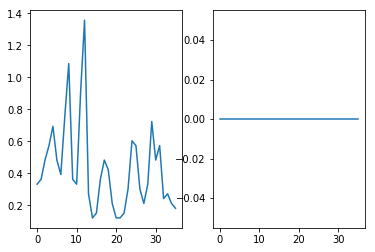

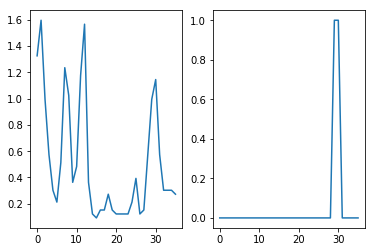

next band


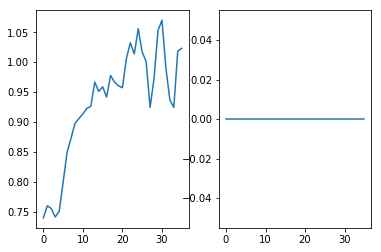

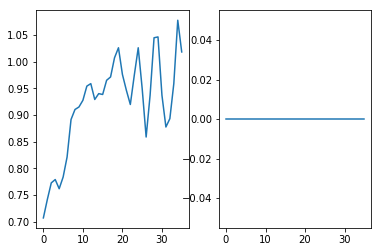

In [30]:
common = set(good_inds6_new) & set(good_inds7_new)

for i in common:
    signal = samples[i,:]
    fig,ax = plt.subplots(1,2)
    ax[0].plot(signal)
    
    test = thresholding_algo(signal, lag,thresh,influence)
    ax[1].plot(test['signals'])
    plt.show()
    
print('next band')
for i in common:
    signal = samples7[i,:]
    fig,ax = plt.subplots(1,2)
    ax[0].plot(signal)
    
    test = thresholding_algo(signal, lag,thresh,influence)
    ax[1].plot(test['signals'])
    plt.show()

## Look at neighborhoods so as to take into account background signal

In [29]:
nbr = 21
side = int(np.floor(nbr/2))
rows,cols = data_ls[0].shape
rows,cols

(2348, 5519)

In [30]:
goes_stack_7 = np.array(data_ls7)
goes_stack_6 = np.array(data_ls)
det_map = np.zeros(goes_stack_7.shape[1:])

In [31]:
## define a function to grab a window around a center pixel
def getWindow(arr, r,c,nbr=3, band=6):
    
    rows,cols = arr.shape[1:]
    
    side = int(np.floor(nbr/2))
    # set the window, taking into account borders (take relevant pixels)
    r_dif_L = r - side # 
    c_dif_L = c - side
    r_dif_R = r + side # 
    c_dif_R = c + side

    r_start = max(0, r_dif_L)
    r_end = min(r_dif_R, rows)
    c_start = max(0, c_dif_L)
    c_end = min(c_dif_R, cols)

    # extract the pixels and mask 'nodata' as vals < 0
    wi_img = arr[:, r_start:r_end, c_start:c_end]
    
    if band <=6:
        wi_ma = np.ma.masked_less(wi_img,0)
        return wi_ma
    else:
        return wi_img
    

    

## from the creation of the thematic raster array, pixels with value == 13 have agreement between bands 6 and 7. 

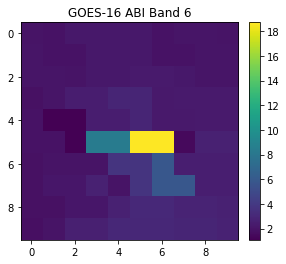

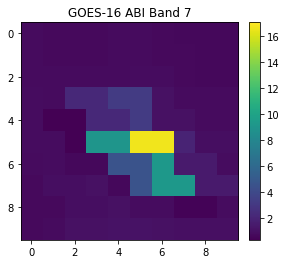

In [83]:
dr, dc = np.where(goes_detections == 13)
dr, dc
goes_detections[dr,dc]

t_win_yes = getWindow(goes_stack_6, dr[0], dc[0], 10)
cmin6,cmax6 = np.min(t_win_yes), np.max(t_win_yes)
a = plt.imshow(t_win_yes[24,:,:], vmin=cmin6, vmax=cmax6)
plt.title('GOES-16 ABI Band 6')
colorbar(a)
plt.show()

t_win_yes = getWindow(goes_stack_7, dr[0], dc[0], 10)
cmin7,cmax7 = np.min(t_win_yes), np.max(t_win_yes)
a = plt.imshow(t_win_yes[24,:,:], vmin=cmin7, vmax=cmax7)
plt.title('GOES-16 ABI Band 7')
colorbar(a)
plt.show()

#### Also check a window that is $\sqrt{100^2 + 100^2}$ km to the NE

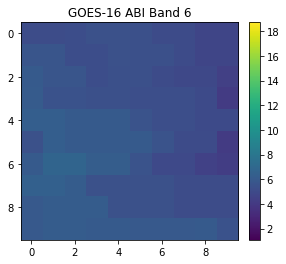

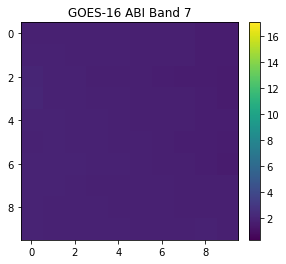

In [85]:
t_win_no = getWindow(goes_stack_6, dr[0]+100, dc[0]+100, 10)
a = plt.imshow(t_win_no[24,:,:], vmin=cmin6, vmax=cmax6)
plt.title('GOES-16 ABI Band 6')
colorbar(a)
plt.show()

t_win_no = getWindow(goes_stack_7, dr[0]+100, dc[0]+100, 10)
a = plt.imshow(t_win_no[24,:,:], vmin=cmin7, vmax=cmax7)
plt.title('GOES-16 ABI Band 7')
colorbar(a)
plt.show()

## dr,dc are the rows/cols where the detection raster == 13. so the plot call for pr,pc with the thicker line is detection time series

## make some plots for band 7

band6 and band7 maxSTD agreement
 band7


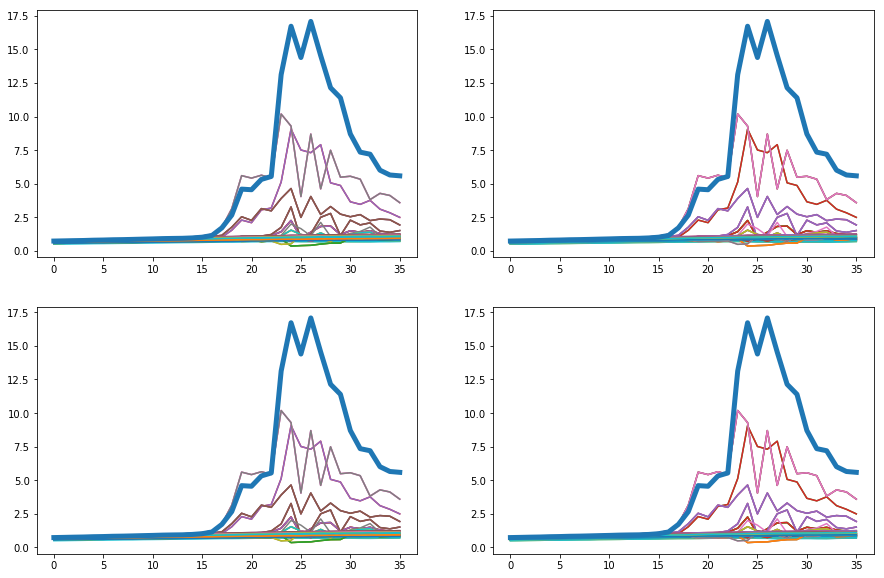

random elsewhere


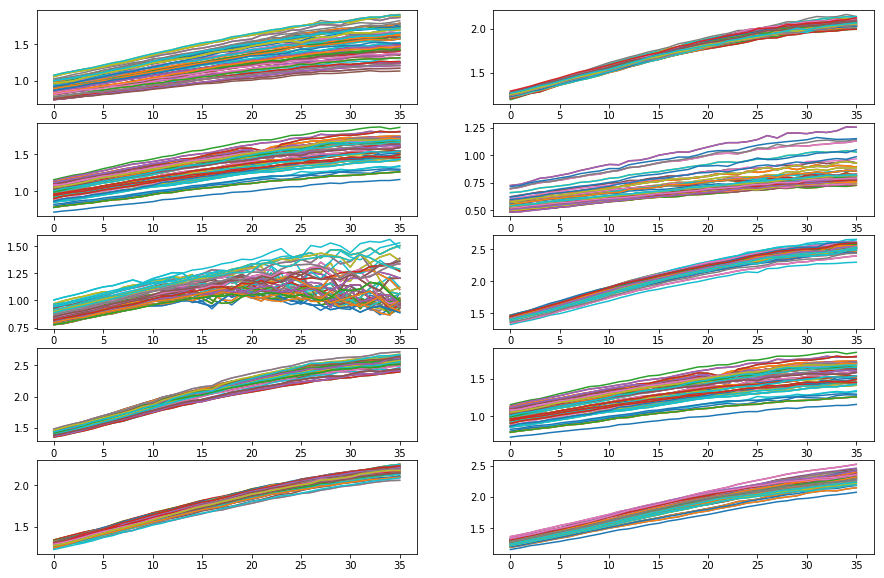

In [86]:
## make some plots

# determine number of rows
ncols = 2
nrows = int((len(dr) * len(dc)) / ncols)

# good plots
print('band6 and band7 maxSTD agreement\n band7')
plot_stack = goes_stack_7
fig, ax = plt.subplots(nrows, ncols, figsize=(15,10))
for i,pr in enumerate(dr):
    for j,pc in enumerate(dc):
        
        plot_data = getWindow(plot_stack, pr, pc, nbr=10, band=7)
        ax[i,j].plot(np.reshape(np.rollaxis(plot_data,0,3), (plot_data.shape[1]*plot_data.shape[2], plot_data.shape[0])).T)
        ax[i,j].plot(plot_stack[:,pr,pc], linewidth=5)
        
        
plt.show()
        

        
print('random elsewhere')
num_rand=10
ran = np.random.randn(num_rand)*100 + 100
nr_rows = int(num_rand/ncols)
fig, ax = plt.subplots(nr_rows, ncols, figsize=(15,10))
j=0
for i,ra in enumerate(ran):
    
    if i>4:
        j=1
        i-=5
        
    plot_data = getWindow(plot_stack, dr[1] + int(ra), dc[1] + int(ra), nbr=10, band=7)
    ax[i,j].plot(np.reshape(np.rollaxis(plot_data,0,3), (plot_data.shape[1]*plot_data.shape[2], plot_data.shape[0])).T)
plt.show()
    


## make some plots for band 6

band6 and band7 maxSTD agreement
 band6


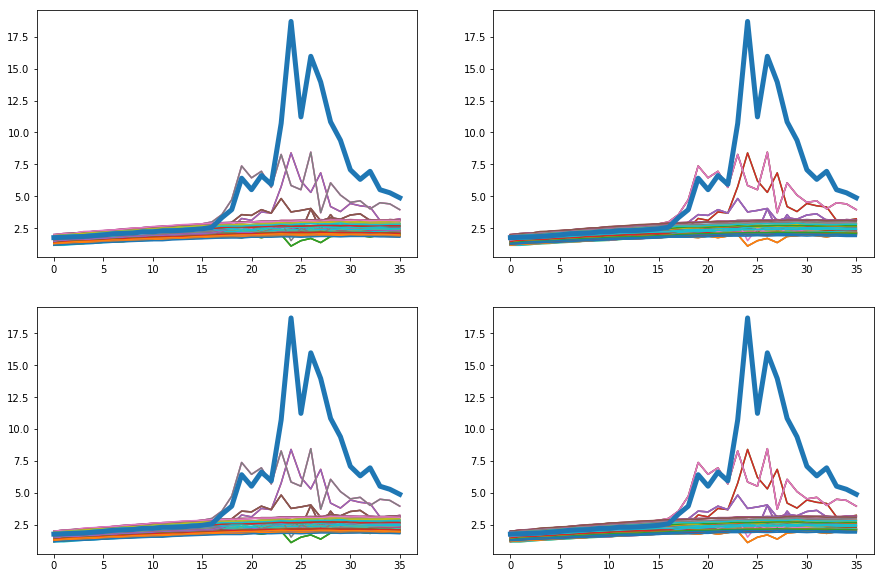

random elsewhere


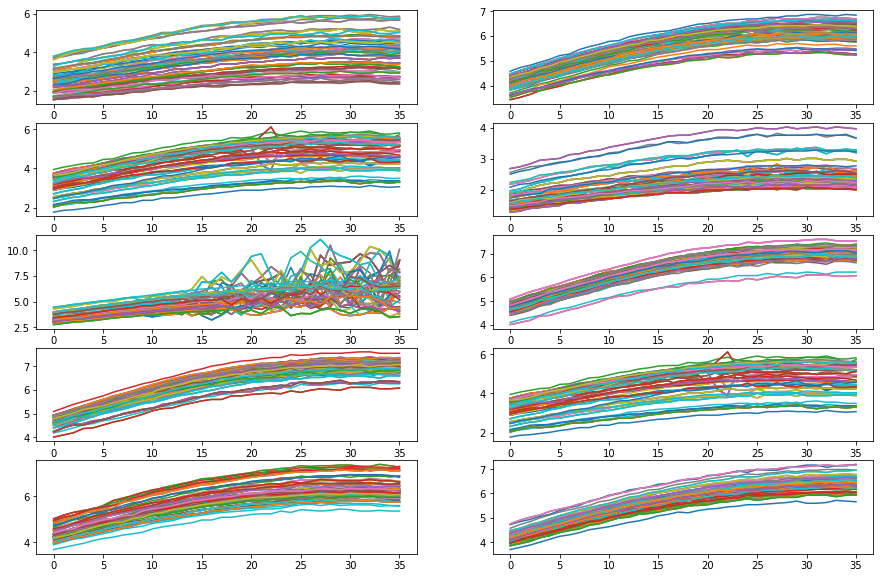

In [87]:
## make some plots

# determine number of rows
ncols = 2
nrows = int((len(dr) * len(dc)) / ncols)

# good plots
print('band6 and band7 maxSTD agreement\n band6')
plot_stack = goes_stack_6
fig, ax = plt.subplots(nrows, ncols, figsize=(15,10))
for i,pr in enumerate(dr):
    for j,pc in enumerate(dc):
        
        plot_data = getWindow(plot_stack, pr, pc, nbr=10, band=6)
        ax[i,j].plot(np.reshape(np.rollaxis(plot_data,0,3), (plot_data.shape[1]*plot_data.shape[2], plot_data.shape[0])).T)
        ax[i,j].plot(plot_stack[:,pr,pc], linewidth=5)
        
        
plt.show()
        

        
print('random elsewhere')
num_rand=10
#ran = np.random.randn(num_rand)*100 + 100
nr_rows = int(num_rand/ncols)
fig, ax = plt.subplots(nr_rows, ncols, figsize=(15,10))
j=0
for i,ra in enumerate(ran):
    
    if i>4:
        j=1
        i-=5
        
    plot_data = getWindow(plot_stack, dr[1] + int(ra), dc[1] + int(ra), nbr=10, band=6)
    ax[i,j].plot(np.reshape(np.rollaxis(plot_data,0,3), (plot_data.shape[1]*plot_data.shape[2], plot_data.shape[0])).T)
plt.show()
    


## Look @ RX Anomaly detector

In [88]:
def calcRX(sample_arr, big_arr, pix_r, pix_c):
    
    try:
        shp = (sample_arr.shape[1]*sample_arr.shape[2], sample_arr.shape[0])
        # set up the parameters
        S = np.cov(np.reshape(np.rollaxis(sample_arr,0,3), shp).T)
        x = np.expand_dims(big_arr[:, pix_r, pix_c], 1)
        u = np.expand_dims(np.mean(np.reshape(np.rollaxis(sample_arr,0,3), shp), axis=0), 1)

        # calculate regular and demeaned value
        rx = np.dot(np.dot(x.T, np.linalg.inv(S)), x)
        rxu = np.dot(np.dot((x-u).T, np.linalg.inv(S)), (x-u))

        return rx[0][0], rxu[0][0]
    
    except: # return no data
        return(-9999,-9999)

# test it out on the 'targets'
print('"targets"')
for i,pr in enumerate(dr):
    for j,pc in enumerate(dc):
        
        local_data = getWindow(plot_stack, pr, pc, nbr=10, band=6)
        test1, test2 = calcRX(local_data, plot_stack, pr, pc)
        print(test1, test2)
        
        
# test it out on the random samples
print('\nrandom')
for i,ra in enumerate(ran):
    
    local_data = getWindow(plot_stack, dr[1] + int(ra), dc[1] + int(ra), nbr=10, band=6)
    test1, test2 = calcRX(local_data, plot_stack, pr, pc)
    print(test1, test2)
    


"targets"
571.1785373948478 48.45294837559928
560.3470908621812 48.44171808021264
571.1785373948478 48.45294837559928
560.3470908621812 48.44171808021264

random
10321079.66148187 10264383.911943536
3105825.925111338 3094935.423434508
10266.400880980167 8044.727260219937
2531014.0557639403 2472799.03510434
2372508.1458106795 2379874.2083360213
1933408.575455674 1876515.8507395443
5687976.225540173 5671159.144141039
2777432.113588925 2785431.486196447
3105825.925111338 3094935.423434508
3433486.7576982453 3414417.053601639


In [106]:
import spectral

ModuleNotFoundError: No module named 'spectral'

In [37]:
int(data_ls[0].shape[0] / 10)

234

In [102]:
full_rx = False

if full_rx:
    # run on full image for band 6
    rx_map = np.zeros(goes_stack_7.shape[1:]) + -9999.
    rxu_map = np.zeros(goes_stack_7.shape[1:]) + -9999.

    rows,cols = data_ls[0].shape
    cnt=0
    for r in range(rows):
        for c in range(cols):

            if (cnt % 1000) == 0:
                print('on pixel {} of {}'.format(cnt+1, rows*cols))

            local_data = getWindow(goes_stack_6, r, c, nbr=10, band=6)
            if np.mean(local_data) < -8000:
                continue

            # extract a feature
            r1, r2 = calcRX(local_data, goes_stack_6, r, c)
            rx_map[r,c] = r1
            rxu_map[r,c] = r2

            cnt+=1
            
else: # run on blocks, not individual pixels
    fact = 10
    rows = int(data_ls[0].shape[0] / fact)
    cols = int(data_ls[0].shape[1] / fact)
    
    rx_map = np.zeros((rows,cols)) + -9999.
    rxu_map = np.zeros((rows,cols)) + -9999.
    
    cnt=0
    for r in range(rows):
        for c in range(cols):

            

            local_data = getWindow(goes_stack_7, r*fact, c*fact, nbr=10, band=6)
            if np.mean(local_data) < -8000:
                cnt+=1
                continue
                
            if np.all(np.ma.is_masked(local_data.flatten())):
                cnt+=1
                continue
                
            if (cnt % 1000) == 0:
                print('on pixel {} of {}'.format(cnt+1, rows*cols))

            # extract a feature
            r1, r2 = calcRX(local_data, goes_stack_7, r, c)
            rx_map[r,c] = r1
            rxu_map[r,c] = r2

            cnt+=1


on pixel 5001 of 128934
on pixel 10001 of 128934
on pixel 14001 of 128934
on pixel 15001 of 128934
on pixel 16001 of 128934
on pixel 19001 of 128934
on pixel 20001 of 128934
on pixel 21001 of 128934
on pixel 22001 of 128934
on pixel 23001 of 128934
on pixel 24001 of 128934
on pixel 25001 of 128934
on pixel 26001 of 128934
on pixel 28001 of 128934
on pixel 29001 of 128934
on pixel 30001 of 128934
on pixel 31001 of 128934
on pixel 32001 of 128934
on pixel 33001 of 128934
on pixel 34001 of 128934
on pixel 35001 of 128934
on pixel 36001 of 128934
on pixel 37001 of 128934
on pixel 38001 of 128934
on pixel 39001 of 128934
on pixel 40001 of 128934
on pixel 41001 of 128934
on pixel 42001 of 128934
on pixel 44001 of 128934
on pixel 45001 of 128934
on pixel 46001 of 128934
on pixel 47001 of 128934
on pixel 49001 of 128934
on pixel 50001 of 128934
on pixel 51001 of 128934
on pixel 52001 of 128934
on pixel 55001 of 128934
on pixel 56001 of 128934
on pixel 57001 of 128934
on pixel 58001 of 128934
o

## look at histograms and plots of RX maps

In [103]:
r1, r2

(135239.03994482293, 262130.4424916073)

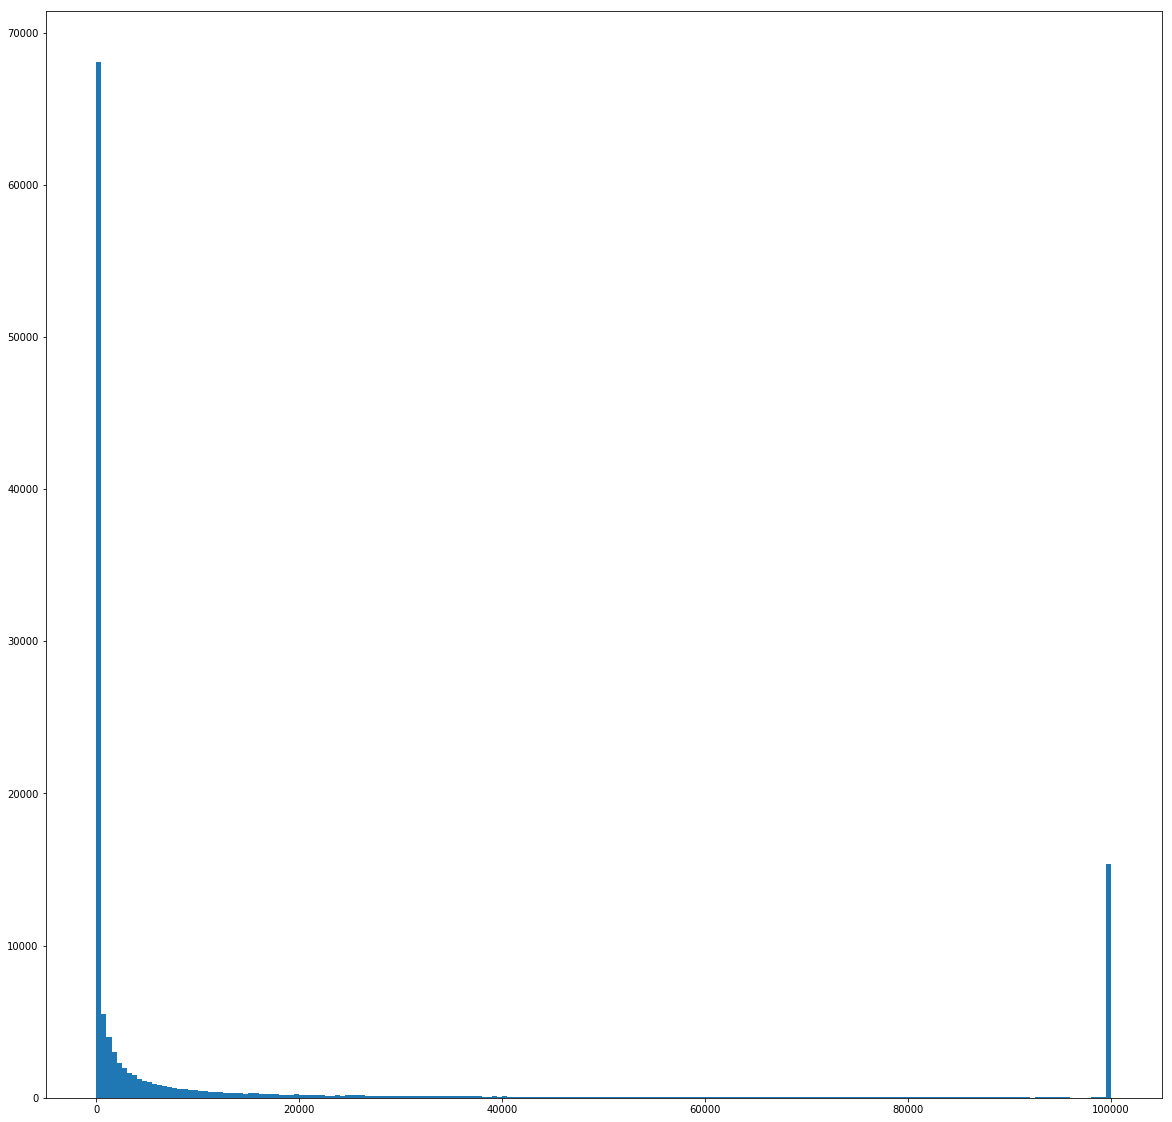

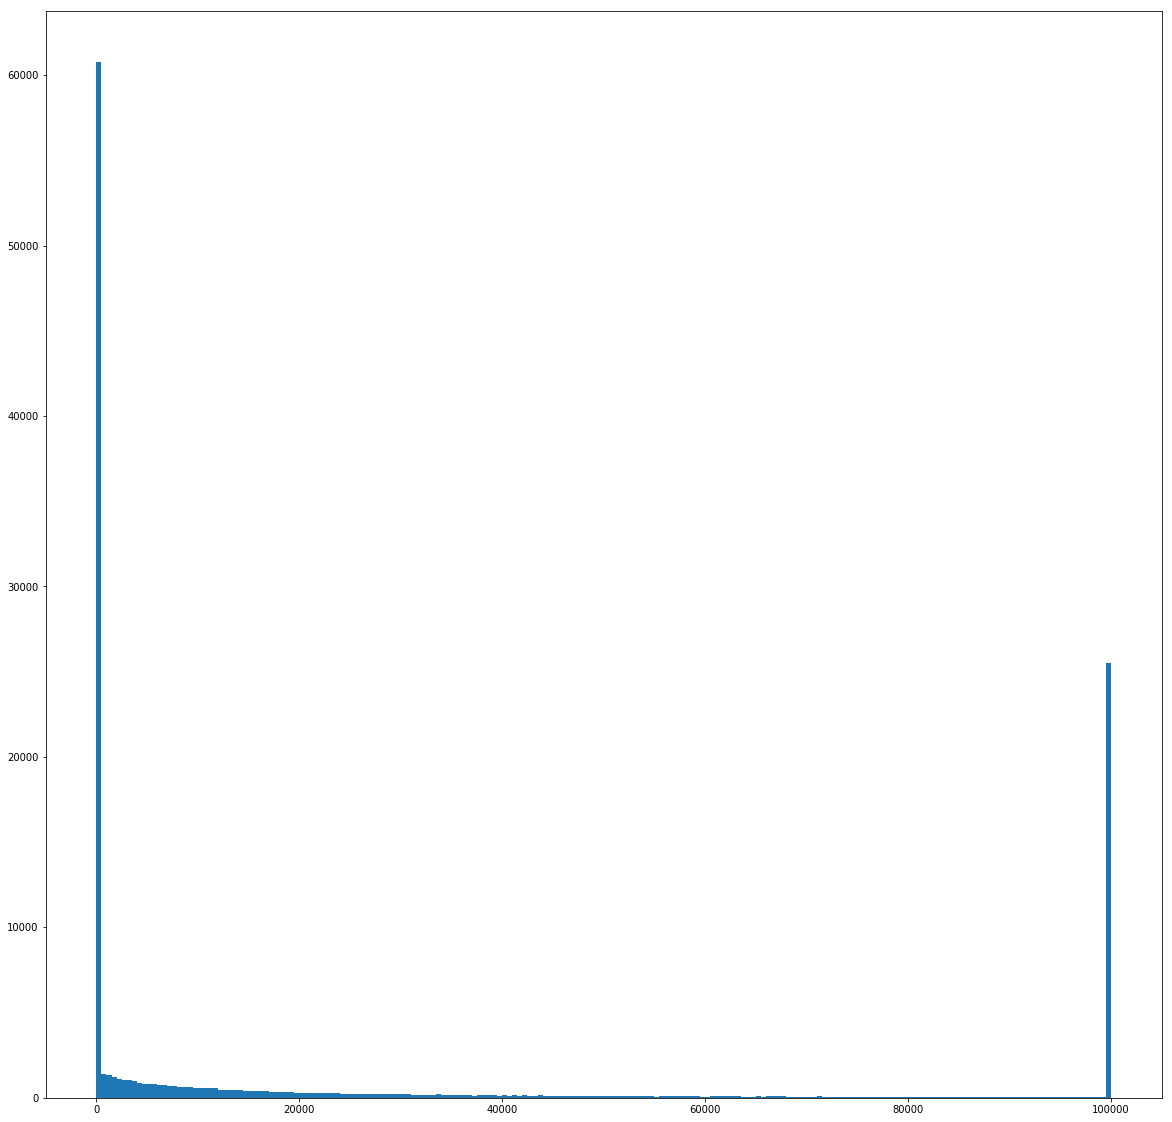

In [104]:
n_bins = 200

fig, ax = plt.subplots(figsize=(20,20))
pim = np.ma.masked_equal(rx_map, -9999)
pim = np.clip(pim, 0, 100000)
plt.hist(pim.flatten(), bins=n_bins)
plt.show()

fig, ax = plt.subplots(figsize=(20,20))
pim = np.ma.masked_equal(rxu_map, -9999)
pim = np.clip(pim, 0, 100000)
plt.hist(pim.flatten(), bins=n_bins)
plt.show()

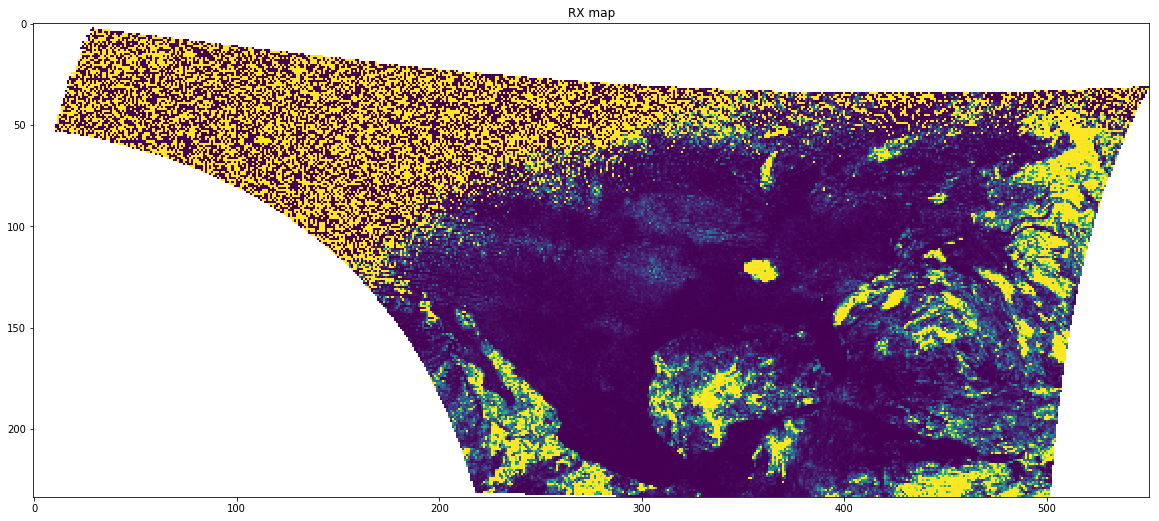

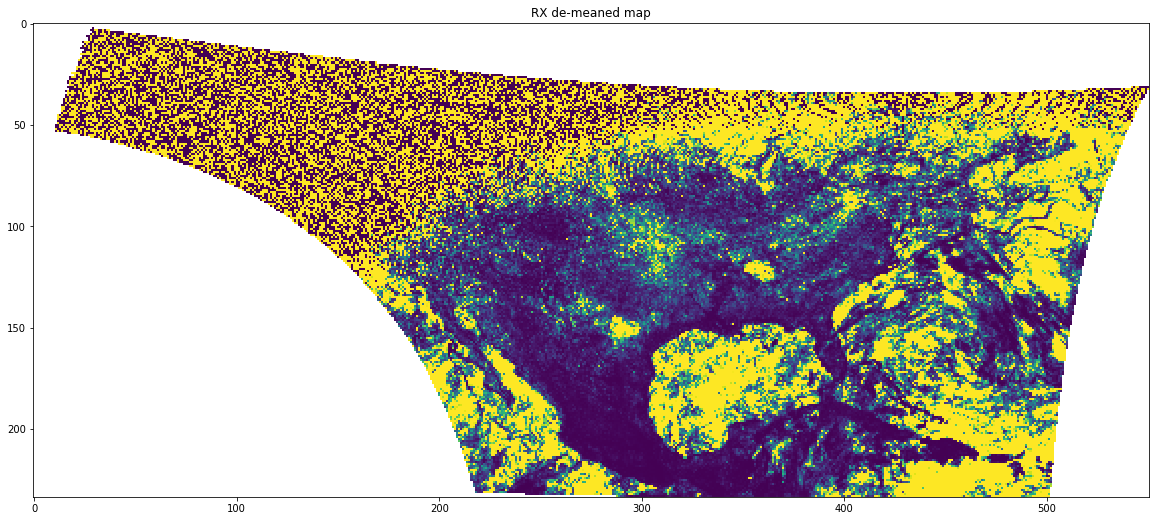

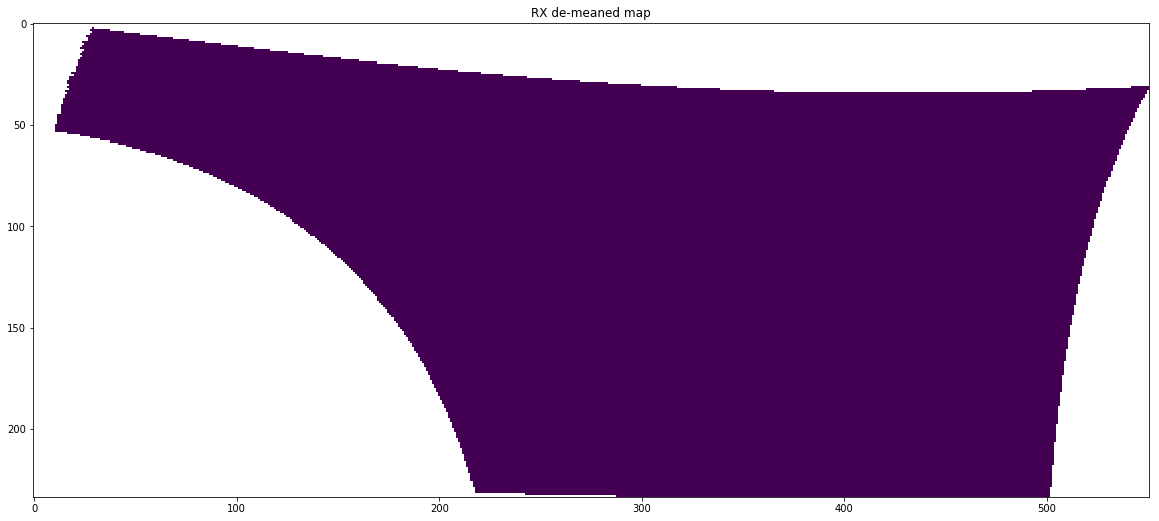

In [105]:
fig, ax = plt.subplots(figsize=(20,20))
pim = np.ma.masked_equal(rx_map, -9999)
pim = np.clip(pim, 0, 100000)
plt.imshow(np.ma.masked_equal(pim, -9999))
plt.title('RX map')
plt.show()

fig, ax = plt.subplots(figsize=(20,20))
pim = np.ma.masked_equal(rxu_map, -9999)
pim = np.clip(pim, 0, 100000)
plt.imshow(np.ma.masked_equal(pim, -9999))
plt.title('RX de-meaned map')
plt.show()

fig, ax = plt.subplots(figsize=(20,20))
pim1 = np.ma.masked_equal(rxu_map, -9999)
pim1 = np.clip(pim, 0, 100000)
pim2= np.ma.masked_equal(rxu_map, -9999)
pim2 = np.clip(pim, 0, 100000)
plt.imshow(np.ma.masked_equal(pim1, -9999) - np.ma.masked_equal(pim2, -9999))
plt.title('RX de-meaned map')
plt.show()
    

In [87]:
# write out the RX maps
a = grid_ls[23].GetGeoTransform()
b = tuple([item*fact if (i==1) or (i==5) else item for i,item in enumerate(a)])
b,a

((-152.10928344726562,
  0.1796745843571108,
  0.0,
  56.761451721191406,
  0.0,
  -0.17968531564715773),
 (-152.10928344726562,
  0.01796745843571108,
  0.0,
  56.761451721191406,
  0.0,
  -0.017968531564715774))

In [88]:
from osgeo import gdal, osr
driver = gdal.GetDriverByName('GTiff')
# rows,cols = data_ls[23].shape

out_folder = '../../outputs'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    
for subname, darr in zip(['rx', 'rxu'], [rx_map, rxu_map]):  
    fname = dts[23][0] + "_" + date_ls[23].replace('-','') + '_GOES_band6_{}_map.tif'.format(subname)
    fname = os.path.join(out_folder, fname)
    dst_ds = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
    #dst_ds.SetGeoTransform(grid_ls[23].GetGeoTransform())
    
    # update geotransform to include factor if it was used
    gtfm = grid_ls[23].GetGeoTransform()
    gtfm_fact = tuple([item*fact if (i==1) or (i==5) else item for i,item in enumerate(gtfm)])
    dst_ds.SetGeoTransform(gtfm_fact)
    
    #srs = osr.SpatialReference()
    #srs.ImportFromWkt(projInfo)
    dst_ds.SetProjection(grid_ls[23].GetProjection()) 

    # Write out_arr to band
    dst_ds.GetRasterBand(1).WriteArray(darr)

    # Flush to disk and close file
    dst_ds.FlushCache()
    dst_ds = None

In [ ]:
S = np.cov(np.reshape(np.rollaxis(plot_data,0,3), new_shp).T)
x = np.expand_dims(plot_stack[:,pr,pc], 1)
u = np.expand_dims(np.mean(np.reshape(np.rollaxis(plot_data,0,3), new_shp), axis=0), 1)
rx = np.dot(np.dot(x.T, np.linalg.inv(S)), x)
rxu = np.dot(np.dot((x-u).T, np.linalg.inv(S)), (x-u))

x.T.shape, np.linalg.inv(S).shape, x.shape, rx.shape

rx, rxu[0][0]

## check out seasonal decomposition algorithm

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


5918832


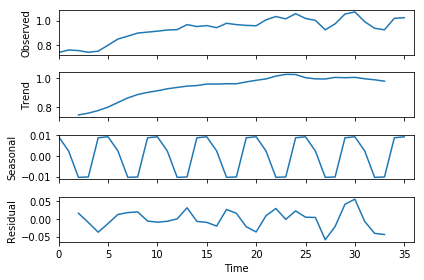

5918831


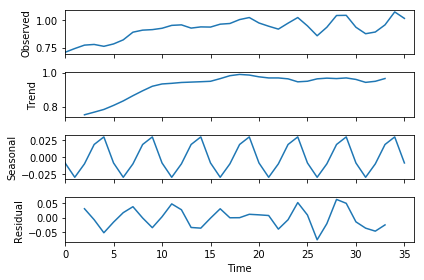

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i in common:
    print(i)
    series = list(samples7[i,:])
    result = seasonal_decompose(series, model='additive', freq=5)
    # print(result.trend)
    # print(result.seasonal)
    # print(result.resid)
    # print(result.observed)
    result.plot()
    plt.show()

In [95]:
common

{5918831, 5918832}

In [90]:
## just a test, nothing to see here
from random import randrange
series = [i+randrange(10) for i in range(1,100)]
result = seasonal_decompose(series, model='additive', freq=1)